# - Fixed Income Allocation Strategy

**Objective:** Dynamic fixed-income allocation for changing geopolitical and economic policy regimes 
**Primary Mandate:** Capital preservation 
**Secondary Mandate:** Positive risk-adjusted returns


## 1. Setup & Configuration

In [21]:
# =============================================================================
# SETUP & CONFIGURATION
# =============================================================================

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from copy import deepcopy

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print("="*80)
print(" " * 20 + " - FIXED INCOME STRATEGY")
print("="*80)
print("\n Libraries imported successfully")

# =============================================================================
# FILE PATHS update here
# =============================================================================

PATH_INDICATORS_RAW = Path("master_indicators_dataset_monthly.csv")
PATH_INDICATORS_PROCESSED = Path("master_indicators_dataset_processed.csv")
PATH_ASSETS = Path("master_asset_data.csv")
OUTPUT_DIR = Path("Outputs/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n Output directory created: {OUTPUT_DIR}")

# =============================================================================
# REGIME DETECTION PARAMETERS
# =============================================================================

Z_WINDOW = 60 # Z-score lookback window (months)
PCT_WINDOW = 180 # Percentile calculation window (months)
VAR_WINDOW = 36 # Variance window (months)
SHORT_GAP_MAX = 3 # Max gap for forward-fill (months)
MIN_REGIME_MONTHS = 6 # Minimum regime duration for smoothing
MIN_COV_MONTHS = 8 # Minimum months for covariance estimation

print("\n Regime detection parameters configured")
print(f" - Z-score window: {Z_WINDOW} months")
print(f" - Percentile window: {PCT_WINDOW} months")
print(f" - Regime smoothing: {MIN_REGIME_MONTHS} months")

# =============================================================================
# ALLOCATION PARAMETERS
# =============================================================================

REBALANCE_FREQ = "Q" # Quarterly rebalancing
SMOOTH_MONTHS = 3 # Moving average smoothing window
SHRINKAGE = 0.2 # Covariance shrinkage factor

print("\n Allocation parameters configured")
print(f" - Rebalancing: {REBALANCE_FREQ} (Quarterly)")
print(f" - Smoothing window: {SMOOTH_MONTHS} months")

# =============================================================================
# RULE-BASED ENGINE PARAMETERS
# =============================================================================

MAX_TILT_PP = 0.15 # Maximum single tilt (percentage points)
TOTAL_MAX_TILT = 0.15 # Total maximum tilt across all classes
FALLBACK_STRATEGY = "gov" # Fallback to government bonds if regime unclear

print("\n Rule-based engine parameters configured")
print(f" - Max single tilt: {MAX_TILT_PP*100}%")
print(f" - Total max tilt: {TOTAL_MAX_TILT*100}%")

# =============================================================================
# GLOBAL CONSTANTS
# =============================================================================

ANNUAL = 12 # Months per year (for annualization)
SQRT_ANN = np.sqrt(ANNUAL) # Square root for volatility annualization
EPS = 1e-9 # Small epsilon to prevent division by zero

# =============================================================================
# OUTPUT CONTROL
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

WRITE_OUTPUTS = True # Set to False to suppress file writes

if WRITE_OUTPUTS:
 print("\n Output writing ENABLED (files will be saved to disk)")
else:
 print("\n Output writing DISABLED (no files will be saved)")

print("\n" + "="*80)
print("CONFIGURATION COMPLETE - Ready to proceed")
print("="*80)

print("\n Rule-based engine parameters configured")



                     - FIXED INCOME STRATEGY

 Libraries imported successfully

 Output directory created: Outputs

 Regime detection parameters configured
 - Z-score window: 60 months
 - Percentile window: 180 months
 - Regime smoothing: 6 months

 Allocation parameters configured
 - Rebalancing: Q (Quarterly)
 - Smoothing window: 3 months

 Rule-based engine parameters configured
 - Max single tilt: 15.0%
 - Total max tilt: 15.0%

 Output writing ENABLED (files will be saved to disk)

CONFIGURATION COMPLETE - Ready to proceed

 Rule-based engine parameters configured


## 2. Regime Detection Framework

**Purpose:** Classify market environments into four regimes based on macro indicators

**Regimes:**
- **Crisis** (Top 20% stress): VIX spike, wide credit spreads, high policy uncertainty
- **Risk-Off** (60-80%): Elevated uncertainty, defensive positioning
- **Neutral** (40-60%): Balanced market conditions
- **Risk-On** (Bottom 40%): Low volatility, tight spreads, investor confidence

**Methodology:**
1. Load and normalize indicators (VIX, Credit Spreads, EPU, Unemployment)
2. Calculate z-scores and percentile rankings
3. Combine into single regime score
4. Classify based on percentile thresholds (p40, p60, p80)

In [22]:
# =============================================================================
# REGIME DETECTION FRAMEWORK - UTILITY FUNCTIONS
# =============================================================================

def load_and_index(path):
    
    df = pd.read_csv(path)
    
    # Try multiple date formats
    date_col = df.columns[0]
    for fmt in ('%Y-%m-%d', '%d-%m-%Y', '%m/%d/%Y', '%Y/%m/%d'):
        try:
            df[date_col] = pd.to_datetime(df[date_col], format=fmt)
            break
        except:
            continue
    
    # Fallback: infer format
    if df[date_col].dtype != 'datetime64[ns]':
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    df = df.sort_values(date_col).reset_index(drop=True)
    df.set_index(date_col, inplace=True)
    
    # Convert to month start timestamps (NOT Period)
    df.index = df.index.to_period('M').to_timestamp()
    
    return df



def rolling_zscore(series, window=Z_WINDOW):
    
    mean = series.rolling(window, min_periods=12).mean()
    std = series.rolling(window, min_periods=12).std()
    return (series - mean) / std


def last_rank(arr):
    
    s = pd.Series(arr)
    return float(s.rank(pct=True).iloc[-1])


def rolling_pct_rank(series, window=PCT_WINDOW):
    
    rank = series.rolling(window, min_periods=12).apply(last_rank, raw=False)
    early_mask = rank.isna()
    
    if early_mask.any():
        exp_rank = series.expanding(min_periods=3).apply(last_rank, raw=False)
        rank.loc[early_mask] = exp_rank.loc[early_mask]
    
    return rank


def compute_z_score(series, window=Z_WINDOW):
    
    return rolling_zscore(series, window=window)


def compute_percentile(series, window=PCT_WINDOW):
    
    return rolling_pct_rank(series, window=window)



def normalize_by_1_99(series, z_window=Z_WINDOW, pct_window=PCT_WINDOW):

    p01 = series.rolling(pct_window, min_periods=12).quantile(0.01)
    p99 = series.rolling(pct_window, min_periods=12).quantile(0.99)
    
    # Expanding fallback for early periods
    early_mask = p01.isna()
    if early_mask.any():
        p01.loc[early_mask] = series.expanding(min_periods=3).quantile(0.01).loc[early_mask]
        p99.loc[early_mask] = series.expanding(min_periods=3).quantile(0.99).loc[early_mask]
    
    # Normalize
    normalized = (series - p01) / (p99 - p01 + EPS)
    
    return normalized.clip(0, 1)


print("\n Regime detection utility functions loaded:")




 Regime detection utility functions loaded:


## 3. Build Regime Signal

**Process:**
1. **Primary Score:** VIX + Credit Spreads (weighted 60%)
2. **Secondary Score:** EPU + Unemployment YoY (weighted 40%)
3. **Combined Score:** Weighted average of Primary + Secondary
4. **Regime Assignment:** Based on combined score percentiles

**Output:** Time series of regime classifications (Crisis, Risk-Off, Neutral, Risk-On)

In [23]:
# =============================================================================
# BUILD REGIME SIGNAL
# =============================================================================

print("="*80)
print(" " * 25 + "BUILDING REGIME SIGNAL")
print("="*80)

print("\n[1/5] Loading indicators data...")
ind = load_and_index(PATH_INDICATORS_RAW)

# Ensure Timestamp index (convert from Period if needed)
if isinstance(ind.index, pd.PeriodIndex):
    ind.index = ind.index.to_timestamp()

print(f"   Loaded {len(ind)} months of data")
print(f"   Date range: {ind.index[0]} to {ind.index[-1]}")
print(f"   Columns: {list(ind.columns)}")

# Map actual column names to expected names
column_mapping = {
    'VIX_Volatility_Index': 'VIX',
    'IG_Spread_Combined_bps': 'IG_Treasury_Spread',
    'HY_Spread_Combined_bps': 'HY_Treasury_Spread',
    'Yield_Curve_10Y_2Y_bps': 'Yield_Curve_Spread',
    'Economic_Policy_Uncertainty': 'EPU',
    'Geopolitical_Risk_Index': 'Geopolitical_Risk',
    'Inflation_YoY_Pct': 'Inflation_YoY',
    'Govt_Sp_Per_GDP': 'Govt_Spending_GDP',
    'Unemployment_Rate': 'Unemployment_Rate',
    'Treasury_10Y_Yield': 'Treasury_10Y_Yield'
}

# Rename columns
for old_name, new_name in column_mapping.items():
    if old_name in ind.columns:
        ind.rename(columns={old_name: new_name}, inplace=True)

print(f"   Columns standardized")

# Fill short gaps
market_cols = ['VIX', 'IG_Treasury_Spread', 'HY_Treasury_Spread', 'Yield_Curve_Spread']
for col in market_cols:
    if col in ind.columns:
        ind[col] = ind[col].interpolate(method='linear', limit=SHORT_GAP_MAX, limit_direction='both')

other_cols = [c for c in ind.columns if c not in market_cols]
for col in other_cols:
    ind[col] = ind[col].fillna(method='ffill', limit=SHORT_GAP_MAX)

print(f"   Short gaps filled (max {SHORT_GAP_MAX} months)")

# Calculate derived indicators
if 'Treasury_10Y_Yield' in ind.columns:
    ind['Delta10y_abs'] = ind['Treasury_10Y_Yield'].diff().abs()
    print(f"   Delta 10Y absolute change calculated")

# =============================================================================
# STEP 2: COMPUTE PRIMARY SCORE (EPU + GPR + Inflation + Gov Spending)
# =============================================================================

print("\n[2/5] Computing Primary Score (Policy-Based)...")

W_EPU = 0.60
W_GPR = 0.15
W_INFL = 0.15
W_GOV = 0.10

ind['EPU_z'] = compute_z_score(ind['EPU'], window=Z_WINDOW).clip(-3, 3)
ind['GPR_z'] = compute_z_score(ind['Geopolitical_Risk'], window=Z_WINDOW).clip(-3, 3)
ind['Infl_z'] = compute_z_score(ind['Inflation_YoY'], window=Z_WINDOW).clip(-3, 3)
ind['GovSp_z'] = compute_z_score(ind['Govt_Spending_GDP'], window=Z_WINDOW).clip(-3, 3)

def compute_primary_dynamic(row):
    components = {
        'EPU_z': (row['EPU_z'], W_EPU),
        'GPR_z': (row['GPR_z'], W_GPR),
        'Infl_z': (row['Infl_z'], W_INFL),
        'GovSp_z': (row['GovSp_z'], W_GOV)
    }
    valid = {k: v for k, v in components.items() if pd.notna(v[0])}
    if len(valid) == 0:
        return np.nan
    total_w = sum(v[1] for v in valid.values())
    weighted_sum = sum(v[0] * v[1] for v in valid.values())
    return weighted_sum / total_w

ind['Primary_raw'] = ind.apply(compute_primary_dynamic, axis=1)
ind['Primary_norm'] = normalize_by_1_99(ind['Primary_raw'], pct_window=PCT_WINDOW)

print(f"   Primary score = {W_EPU*100:.0f}% EPU + {W_GPR*100:.0f}% GPR + {W_INFL*100:.0f}% Infl + {W_GOV*100:.0f}% Gov")

# =============================================================================
# STEP 3: COMPUTE SECONDARY SCORE (Market Indicators)
# =============================================================================

print("\n[3/5] Computing Secondary Score (Market-Based)...")

if 'Unemployment_Rate' in ind.columns:
    ind['Unemp_YoY'] = ind['Unemployment_Rate'].diff(12)
    ind['Unemp_adj'] = ind['Unemp_YoY'].fillna(0) + 0.5 * ind['Unemployment_Rate']
else:
    ind['Unemp_adj'] = np.nan

secondary_candidates = []
for col in ['VIX', 'IG_Treasury_Spread', 'HY_Treasury_Spread', 'Unemp_adj', 
            'Yield_Curve_Spread', 'Delta10y_abs']:
    if col in ind.columns or col == 'Unemp_adj':
        secondary_candidates.append(col)

score_cols = []
for col in secondary_candidates:
    ser = ind[col]
    rank = compute_percentile(ser, window=PCT_WINDOW)
    score_col = f"{col}_score"
    ind[score_col] = rank
    score_cols.append(score_col)

if len(score_cols) > 0:
    ind['Secondary_raw'] = ind[score_cols].mean(axis=1, skipna=True)
else:
    ind['Secondary_raw'] = np.nan

ind['Secondary_norm'] = normalize_by_1_99(ind['Secondary_raw'], pct_window=PCT_WINDOW)

print(f"   Secondary components ({len(score_cols)}): {', '.join(secondary_candidates)}")

# =============================================================================
# STEP 4: COMPUTE COMBINED SCORE (Dynamic Inverse-Variance Weighting)
# =============================================================================

print("\n[4/5] Computing Combined Score with Dynamic Weighting...")

varP = ind['Primary_norm'].rolling(VAR_WINDOW, min_periods=12).var()
varS = ind['Secondary_norm'].rolling(VAR_WINDOW, min_periods=12).var()

varP = varP.replace(0, np.nan)
varS = varS.replace(0, np.nan)

varP = varP.fillna(ind['Primary_norm'].expanding(min_periods=12).var())
varS = varS.fillna(ind['Secondary_norm'].expanding(min_periods=12).var())

varP = varP.fillna(varP.mean())
varS = varS.fillna(varS.mean())

ind['wP'] = (1.0 / (varP + EPS)) / ((1.0 / (varP + EPS)) + (1.0 / (varS + EPS)))
ind['wS'] = 1.0 - ind['wP']

ind['Combined'] = ind['wP'] * ind['Primary_norm'] + ind['wS'] * ind['Secondary_norm']

print(f"   Dynamic weights - Primary: {ind['wP'].mean():.1%}, Secondary: {ind['wS'].mean():.1%}")

roll_comb = ind['Combined'].rolling(PCT_WINDOW, min_periods=12)
p40 = roll_comb.quantile(0.4)
p60 = roll_comb.quantile(0.6)
p80 = roll_comb.quantile(0.8)

early_mask = p40.isnull()
if early_mask.any():
    p40.loc[early_mask] = ind['Combined'].expanding(min_periods=3).quantile(0.4).loc[early_mask]
    p60.loc[early_mask] = ind['Combined'].expanding(min_periods=3).quantile(0.6).loc[early_mask]
    p80.loc[early_mask] = ind['Combined'].expanding(min_periods=3).quantile(0.8).loc[early_mask]

ind['p40'] = p40
ind['p60'] = p60
ind['p80'] = p80

print("   Percentile thresholds calculated")

# =============================================================================
# STEP 5: ASSIGN REGIME LABELS
# =============================================================================

print("\n[5/5] Assigning regime labels...")

def assign_regime(row):
    combined = row['Combined']
    p40 = row['p40']
    p60 = row['p60']
    p80 = row['p80']
    
    if pd.isna(combined) or pd.isna(p80):
        return np.nan
    
    if combined > p80:
        return 'Crisis'
    elif combined > p60:
        return 'Risk-Off'
    elif combined > p40:
        return 'Neutral'
    else:
        return 'Risk-On'

ind['Regime_raw'] = ind.apply(assign_regime, axis=1)
ind['Regime_quantile'] = ind['Regime_raw'].copy()
ind['Regime_quantile'] = ind['Regime_quantile'].fillna(method='ffill', limit=MIN_REGIME_MONTHS)

regime_counts = ind['Regime_quantile'].value_counts().sort_index()

print("   Regime classification complete")
print("\nRegime Distribution:")
for regime, count in regime_counts.items():
    pct = (count / len(ind.dropna(subset=['Regime_quantile']))) * 100
    print(f"  {regime:12s}: {count:4d} months ({pct:5.1f}%)")

if WRITE_OUTPUTS:
    ind.to_csv(PATH_INDICATORS_PROCESSED)
    print(f"\n Saved: {PATH_INDICATORS_PROCESSED}")

print("\n" + "="*80)
print(" " * 20 + "REGIME SIGNAL CONSTRUCTION COMPLETE")
print("="*80)


                         BUILDING REGIME SIGNAL

[1/5] Loading indicators data...
   Loaded 1011 months of data
   Date range: 1941-01-01 00:00:00 to 2025-03-01 00:00:00
   Columns: ['Treasury_2Y_Yield', 'Economic_Policy_Uncertainty', 'Geopolitical_Risk_Index', 'CPI_All_Urban_Index', 'Treasury_10Y_Yield', 'Unemployment_Rate', 'VIX_Volatility_Index', 'IG_Spread_Combined_bps', 'HY_Spread_Combined_bps', 'Yield_Curve_10Y_2Y_bps', 'Inflation_YoY_Pct', 'Govt_Sp_Per_GDP']
   Columns standardized
   Short gaps filled (max 3 months)
   Delta 10Y absolute change calculated

[2/5] Computing Primary Score (Policy-Based)...
   Primary score = 60% EPU + 15% GPR + 15% Infl + 10% Gov

[3/5] Computing Secondary Score (Market-Based)...
   Secondary components (6): VIX, IG_Treasury_Spread, HY_Treasury_Spread, Unemp_adj, Yield_Curve_Spread, Delta10y_abs

[4/5] Computing Combined Score with Dynamic Weighting...
   Dynamic weights - Primary: 49.1%, Secondary: 50.9%
   Percentile thresholds calculated

[5/5]

## 4. Visualize Regime Classification

**Visual Analysis:**
- **Top Panel:** Combined regime score with percentile thresholds
- **Middle Panel:** Individual component scores (VIX, Credit Spreads, EPU, Unemployment)
- **Bottom Panel:** Regime timeline with color-coded periods

**Purpose:** Validate regime detection logic and identify key transition points

                         VISUALIZING REGIME CLASSIFICATION

 Visualization saved: Outputs\regime_classification_visualization.png


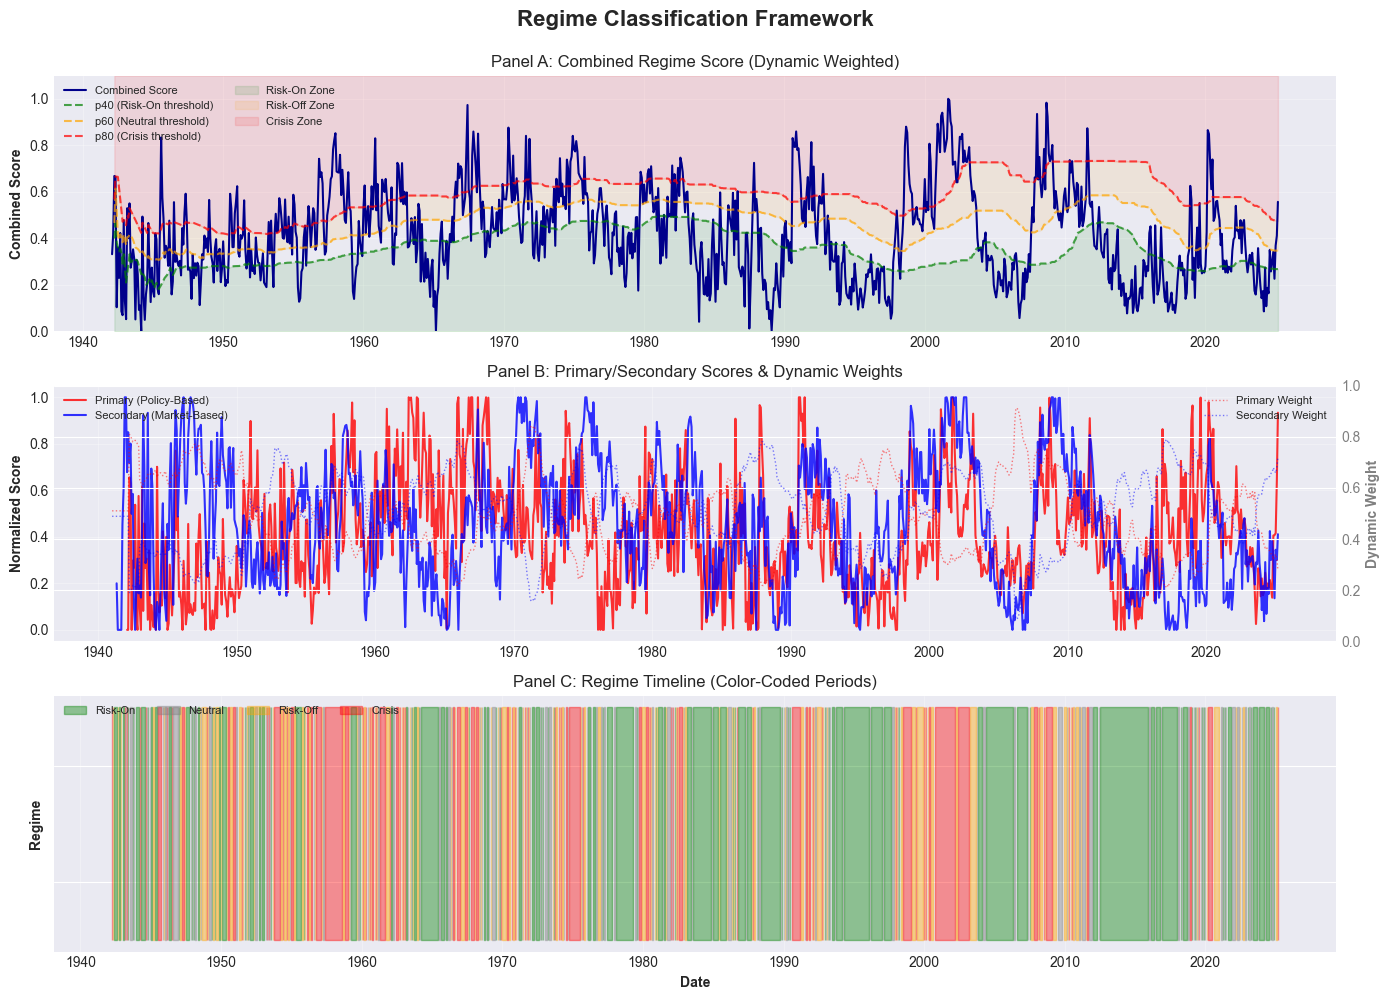


 Regime visualization complete


In [24]:
# =============================================================================
# REGIME VISUALIZATION
# =============================================================================

print("="*80)
print(" " * 25 + "VISUALIZING REGIME CLASSIFICATION")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Regime Classification Framework', fontsize=16, fontweight='bold', y=0.995)

# Ensure dates are Timestamps
if isinstance(ind.index, pd.PeriodIndex):
    dates = ind.index.to_timestamp()
else:
    dates = ind.index

# -----------------------------------------------------------------------------
# PANEL 1: Combined Score with Thresholds
# -----------------------------------------------------------------------------

ax1 = axes[0]

ax1.plot(dates, ind['Combined'], label='Combined Score', color='darkblue', linewidth=1.5)

ax1.plot(dates, ind['p40'], label='p40 (Risk-On threshold)', 
         color='green', linestyle='--', alpha=0.7)
ax1.plot(dates, ind['p60'], label='p60 (Neutral threshold)', 
         color='orange', linestyle='--', alpha=0.7)
ax1.plot(dates, ind['p80'], label='p80 (Crisis threshold)', 
         color='red', linestyle='--', alpha=0.7)

combined_max = ind['Combined'].max()
ax1.fill_between(dates, 0, ind['p40'], alpha=0.1, color='green', label='Risk-On Zone')
ax1.fill_between(dates, ind['p60'], ind['p80'], alpha=0.1, color='orange', label='Risk-Off Zone')
ax1.fill_between(dates, ind['p80'], combined_max * 1.1, alpha=0.1, color='red', label='Crisis Zone')

ax1.set_ylabel('Combined Score', fontweight='bold')
ax1.set_title('Panel A: Combined Regime Score (Dynamic Weighted)', fontsize=12)
ax1.legend(loc='upper left', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, combined_max * 1.1])

# -----------------------------------------------------------------------------
# PANEL 2: Primary vs Secondary Components
# -----------------------------------------------------------------------------

ax2 = axes[1]

ax2.plot(dates, ind['Primary_norm'], label='Primary (Policy-Based)', 
         color='red', linewidth=1.5, alpha=0.8)
ax2.plot(dates, ind['Secondary_norm'], label='Secondary (Market-Based)', 
         color='blue', linewidth=1.5, alpha=0.8)

ax2_twin = ax2.twinx()
ax2_twin.plot(dates, ind['wP'], label='Primary Weight', 
              color='red', linewidth=1, linestyle=':', alpha=0.5)
ax2_twin.plot(dates, ind['wS'], label='Secondary Weight', 
              color='blue', linewidth=1, linestyle=':', alpha=0.5)
ax2_twin.set_ylabel('Dynamic Weight', fontweight='bold', color='gray')
ax2_twin.set_ylim([0, 1])
ax2_twin.tick_params(axis='y', labelcolor='gray')

ax2.set_ylabel('Normalized Score', fontweight='bold')
ax2.set_title('Panel B: Primary/Secondary Scores & Dynamic Weights', fontsize=12)
ax2.legend(loc='upper left', fontsize=8)
ax2_twin.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# PANEL 3: Regime Timeline
# -----------------------------------------------------------------------------

ax3 = axes[2]

colors = {'Risk-On': 'green', 'Neutral': 'gray', 'Risk-Off': 'orange', 'Crisis': 'red'}

for regime, color in colors.items():
    mask = ind['Regime_quantile'] == regime
    if mask.any():
        ax3.fill_between(dates, 0, 1, where=mask.values, alpha=0.4, color=color, label=regime)

ax3.set_ylabel('Regime', fontweight='bold')
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_title('Panel C: Regime Timeline (Color-Coded Periods)', fontsize=12)
ax3.set_yticks([0.25, 0.75])
ax3.set_yticklabels(['', ''])
ax3.legend(loc='upper left', fontsize=8, ncol=4)
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

if WRITE_OUTPUTS:
    output_path = OUTPUT_DIR / 'regime_classification_visualization.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n Visualization saved: {output_path}")

plt.show()

print("\n Regime visualization complete")
print("="*80)


## 5. Load Asset Returns Data

**Asset Universe:**
- **Cash/Short:** US 1M T-Bill, US 6M T-Bill, Short-term Treasury Index, US Treasury 1-3Y
- **Government Long:** US Treasury 10+ Years, US Treasury 20+ Years
- **Investment Grade:** US Corporate IG, US Aggregate
- **High Yield:** US Corporate HY
- **TIPS:** US TIPS 0-5 Years (Short), US TIPS 1-10 Years (Long)
- **Gold:** Gold Index
- **FX/Currency:** CHF, JPY

**Data Processing:**
1. Load from Excel with monthly returns
2. Align with regime indicators (monthly period index)
3. Fill short gaps (max 3 months forward-fill)
4. Validate data quality and coverage

In [25]:
# =============================================================================
# LOAD ASSET RETURNS DATA
# =============================================================================

print("="*80)
print(" " * 25 + "LOADING ASSET RETURNS DATA")
print("="*80)

# Load processed indicators (with regime classifications)
print("\n[1/3] Loading processed indicators...")
ind = pd.read_csv(PATH_INDICATORS_PROCESSED, index_col=0)
ind.index = pd.PeriodIndex(ind.index, freq='M')

print(f"   Indicators loaded: {len(ind)} months")
print(f"   Date range: {ind.index[0]} to {ind.index[-1]}")
print(f"   Regime column present: {'Regime_quantile' in ind.columns}")

# Load asset returns from CSV
print("\n[2/3] Loading asset returns from CSV...")
assets_raw = pd.read_csv(PATH_ASSETS)

# Process date column and set index
assets_raw['Date'] = pd.to_datetime(assets_raw['Date'], format='%d-%m-%Y', errors='coerce')
assets_raw = assets_raw.dropna(subset=['Date'])
assets_raw['Date'] = assets_raw['Date'].dt.to_period('M')
assets_raw = assets_raw.set_index('Date').sort_index()

# Select only numeric columns (exclude any text/metadata columns)
assets = assets_raw.select_dtypes(include=[np.number])

print(f"   Asset returns loaded: {len(assets)} months")
print(f"   Date range: {assets.index[0]} to {assets.index[-1]}")
print(f"   Number of assets: {assets.shape[1]}")
print(f"\n  Asset columns:")
for i, col in enumerate(assets.columns, 1):
    print(f"    {i:2d}. {col}")

# Fill short gaps with forward-fill (max 3 months)
print(f"\n[3/3] Cleaning data...")
assets = assets.fillna(method='ffill', limit=SHORT_GAP_MAX)

# Data quality check
missing_counts = assets.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n   Warning: {missing_counts.sum()} total missing values after cleaning")
    print(f"  Assets with missing data:")
    for asset, count in missing_counts[missing_counts > 0].items():
        pct = (count / len(assets)) * 100
        print(f"    - {asset}: {count} months ({pct:.1f}%)")
else:
    print(f"   No missing values (after forward-fill)")

# Align assets with indicators (use common date range)
common_dates = assets.index.intersection(ind.index)
assets = assets.loc[common_dates]
ind = ind.loc[common_dates]

print(f"\n Data aligned to common date range")
print(f"  - Common period: {common_dates[0]} to {common_dates[-1]}")
print(f"  - Total months: {len(common_dates)}")
print(f"  - Years covered: {len(common_dates) / 12:.1f}")

# Basic statistics
print(f"\n Quick statistics:")
print(f"  - Average monthly return: {assets.mean().mean()*100:.2f}%")
print(f"  - Average monthly volatility: {assets.std().mean()*100:.2f}%")
print(f"  - Median monthly return: {assets.median().median()*100:.2f}%")

print("\n" + "="*80)
print(" " * 20 + "ASSET DATA LOADING COMPLETE")
print("="*80)

                         LOADING ASSET RETURNS DATA

[1/3] Loading processed indicators...
   Indicators loaded: 1011 months
   Date range: 1941-01 to 2025-03
   Regime column present: True

[2/3] Loading asset returns from CSV...
   Asset returns loaded: 661 months
   Date range: 1969-12 to 2024-12
   Number of assets: 15

  Asset columns:
     1. Short-term treasury index
     2. US TIPS 0-5 Years
     3. US TIPS 1-5 years
     4. US Treasury Inflation Notes 1-10 Years
     5. US Aggregate 10 or 10+ Years
     6. US Aggregate
     7. US Corporate HY
     8. US Corporate IG
     9. US Treasury
    10. CHF
    11. Gold
    12. JPY
    13. US treasury 1-3 Year
    14. US Treasury 20+ Years
    15. US Treasury 10+ Years

[3/3] Cleaning data...

  Assets with missing data:
    - US TIPS 0-5 Years: 394 months (59.6%)
    - US TIPS 1-5 years: 421 months (63.7%)
    - US Treasury Inflation Notes 1-10 Years: 350 months (53.0%)
    - US Aggregate 10 or 10+ Years: 279 months (42.2%)
    - US Ag

## 6. Asset Analysis

**Objectives:**
1. **Correlation Analysis:** Understand relationships between assets
2. **Returns & Volatility Statistics:** Calculate key performance metrics
3. **Per-Asset Sharpe Ratios:** Evaluate risk-adjusted returns by regime

**Purpose:** Validate diversification benefits and identify regime-specific behavior

                         CORRELATION ANALYSIS

Calculating asset correlation matrix...
 Correlation heatmap saved: Outputs\correlation_matrix.png


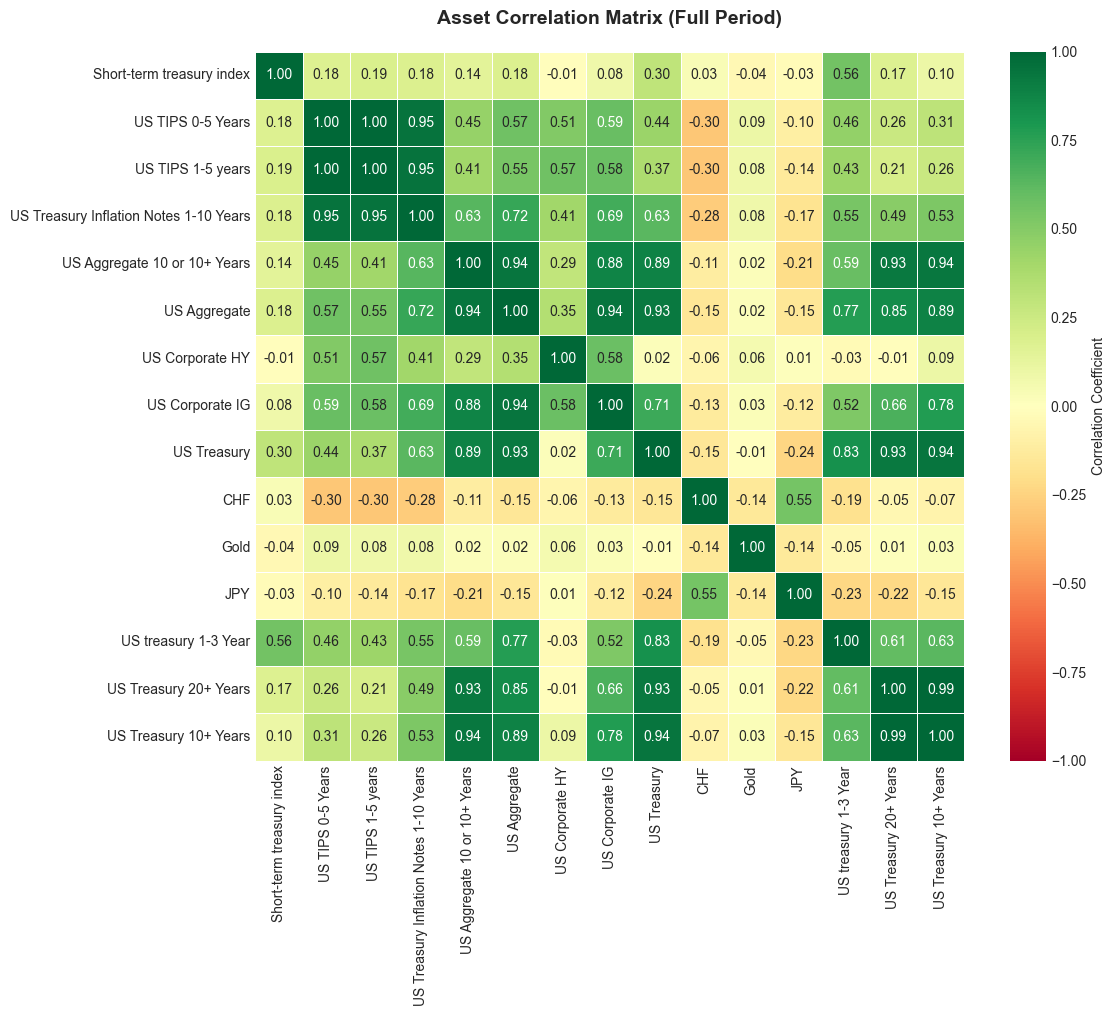


Key Correlation Insights:

  High correlation pairs (|r| > 0.7):
    US TIPS 0-5 Years <-> US TIPS 1-5 years: 0.998
    US Treasury 20+ Years <-> US Treasury 10+ Years: 0.994
    US TIPS 1-5 years <-> US Treasury Inflation Notes 1-10 Years: 0.953
    US TIPS 0-5 Years <-> US Treasury Inflation Notes 1-10 Years: 0.948
    US Aggregate 10 or 10+ Years <-> US Aggregate: 0.943
    US Aggregate <-> US Corporate IG: 0.941
    US Treasury <-> US Treasury 10+ Years: 0.939
    US Aggregate 10 or 10+ Years <-> US Treasury 10+ Years: 0.936
    US Aggregate <-> US Treasury: 0.929
    US Aggregate 10 or 10+ Years <-> US Treasury 20+ Years: 0.928

  Negative correlation pairs (diversifiers):
    US TIPS 1-5 years <-> CHF: -0.303
    US TIPS 0-5 Years <-> CHF: -0.300
    US Treasury Inflation Notes 1-10 Years <-> CHF: -0.277
    US Treasury <-> JPY: -0.241
    JPY <-> US treasury 1-3 Year: -0.228

 Correlation analysis complete


In [26]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

import re

print("="*80)
print(" " * 25 + "CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
print("\nCalculating asset correlation matrix...")
correlation_matrix = assets.corr()

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='RdYlGn',        # Red-Yellow-Green color scheme
            center=0,             # Center colormap at 0
            vmin=-1, vmax=1,      # Correlation range
            square=True,          # Square cells
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Asset Correlation Matrix (Full Period)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

if WRITE_OUTPUTS:
    output_path = OUTPUT_DIR / 'correlation_matrix.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f" Correlation heatmap saved: {output_path}")

plt.show()

# Identify key correlation insights
print("\nKey Correlation Insights:")

# Find highly correlated pairs (>0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   corr))

if high_corr_pairs:
    print(f"\n  High correlation pairs (|r| > 0.7):")
    for asset1, asset2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"    {asset1} <-> {asset2}: {corr:.3f}")
else:
    print("  No highly correlated pairs (|r| > 0.7)")

# Find negative correlations (diversifiers)
neg_corr_pairs = [(correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
                  for i in range(len(correlation_matrix.columns))
                  for j in range(i+1, len(correlation_matrix.columns))
                  if correlation_matrix.iloc[i, j] < 0]

if neg_corr_pairs:
    print(f"\n  Negative correlation pairs (diversifiers):")
    for asset1, asset2, corr in sorted(neg_corr_pairs, key=lambda x: x[2])[:5]:
        print(f"    {asset1} <-> {asset2}: {corr:.3f}")
else:
    print("  No negative correlations found")

print("\n Correlation analysis complete")

In [27]:
# =============================================================================
# RETURNS & VOLATILITY STATISTICS
# =============================================================================

print("\n" + "="*80)
print(" " * 20 + "RETURNS & VOLATILITY STATISTICS")
print("="*80)

# Create output directories
OUT_RETURNS = OUTPUT_DIR / "Returns"
OUT_RETURNS.mkdir(parents=True, exist_ok=True)

# Calculate comprehensive statistics for each asset
print("\nCalculating asset statistics...")

stats_list = []
for col in assets.columns:
    ret = assets[col].dropna()
    
    if len(ret) < 12:
        continue
    
    # Calculate metrics
    ann_ret = ret.mean() * ANNUAL
    ann_vol = ret.std() * SQRT_ANN
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Drawdown
    cum_ret = (1 + ret).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    stats_list.append({
        'Asset': col,
        'Ann. Return': ann_ret,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Months': len(ret)
    })

stats_df = pd.DataFrame(stats_list)

# Display sorted by Sharpe ratio
print("\nAsset Statistics (sorted by Sharpe Ratio):")
print(stats_df.sort_values('Sharpe Ratio', ascending=False).to_string(index=False))

# Save statistics
if WRITE_OUTPUTS:
    stats_path = OUT_RETURNS / 'asset_statistics.csv'
    stats_df.to_csv(stats_path, index=False)
    print(f"\n Statistics saved: {stats_path}")

# =============================================================================
# PER-ASSET SHARPE RATIOS BY REGIME
# =============================================================================

print("\n" + "="*80)
print(" " * 20 + "PER-ASSET SHARPE BY REGIME")
print("="*80)

print("\nCalculating regime-specific Sharpe ratios...")

# Create DataFrame to store per-asset Sharpe by regime
per_asset_sharpe = pd.DataFrame(index=assets.columns, 
                                columns=ind['Regime_quantile'].dropna().unique(), 
                                dtype=float)

for regime in ind['Regime_quantile'].dropna().unique():
    regime_mask = ind['Regime_quantile'] == regime
    regime_dates = ind[regime_mask].index
    
    for asset in assets.columns:
        asset_returns = assets.loc[regime_dates.intersection(assets.index), asset]
        
        if len(asset_returns) >= 12:
            ann_ret = asset_returns.mean() * ANNUAL
            ann_vol = asset_returns.std() * SQRT_ANN
            sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
            per_asset_sharpe.loc[asset, regime] = sharpe

# Display results
print("\nPer-Asset Sharpe Ratios by Regime:")
print(per_asset_sharpe.round(3).to_string())

# Save per-asset Sharpe
if WRITE_OUTPUTS:
    sharpe_path = OUT_RETURNS / 'per_asset_sharpe_by_regime.csv'
    per_asset_sharpe.to_csv(sharpe_path)
    print(f"\n Per-asset Sharpe by regime saved: {sharpe_path}")

# Identify best performers per regime
print("\nBest Performers by Regime:")
for regime in per_asset_sharpe.columns:
    top_asset = per_asset_sharpe[regime].idxmax()
    top_sharpe = per_asset_sharpe.loc[top_asset, regime]
    print(f"  {regime:12s}: {top_asset} (Sharpe: {top_sharpe:.3f})")

print("\n" + "="*80)
print(" " * 20 + "ASSET ANALYSIS COMPLETE")
print("="*80)


                    RETURNS & VOLATILITY STATISTICS

Calculating asset statistics...

Asset Statistics (sorted by Sharpe Ratio):
                                 Asset  Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown  Months
             Short-term treasury index     0.049306         0.010555      4.671388     -0.004643     661
                  US treasury 1-3 Year     0.032508         0.016407      1.981386     -0.052605     395
                          US Aggregate     0.064308         0.054201      1.186480     -0.171801     587
                     US TIPS 0-5 Years     0.029910         0.029213      1.023850     -0.080438     267
                       US Corporate HY     0.083590         0.082794      1.009611     -0.333071     497
                           US Treasury     0.045452         0.046232      0.983115     -0.182950     408
                       US Corporate IG     0.070056         0.071624      0.978112     -0.204614     623
US Treasury Inflation Notes 1-

## 7. Asset Mapping & Strategic Asset Allocation (SAA)

**Purpose:** Map individual assets to asset classes and define baseline SAA

**Asset Class Framework:**

| Asset Class | Role | Instruments |
|-------------|------|-------------|
| **Cash/Short** | Defensive anchor, liquidity | US 1M/6M T-Bill, Short-term Treasury, Treasury 1-3Y |
| **Government_Long** | Duration, flight-to-quality | US Treasury 10+Y, 20+Y |
| **InvestmentGrade** | Core fixed income | US Corporate IG, US Aggregate |
| **HighYield** | Return enhancement | US Corporate HY |
| **TIPS** | Inflation protection | TIPS 0-5Y (Short), TIPS 1-10Y (Long) |
| **Gold** | Crisis hedge | Gold Index |
| **FX/Currency** | Safe haven diversification | CHF, JPY |

**Strategic Asset Allocation (SAA) Baseline:**
- 30% Investment Grade
- 30% Government Long
- 10% TIPS Short
- 10% TIPS Long 
- 10% Cash/Short
- 10% High Yield
- 2% Gold
- 2% FX/Currency (CHF/JPY)

In [28]:
# =============================================================================
# ASSET CLASS MAPPING
# =============================================================================

print("="*80)
print(" " * 25 + "ASSET CLASS MAPPING")
print("="*80)

# Define asset-to-class mapping
# NOTE: Ultra-short treasuries (US 1M/6M T-Bill) prioritized for superior Sharpe
asset_to_class_map = {
    # Cash/Short - Ultra-short treasuries (0% DD, Sharpe 3-4)
    'US6M Tbill': 'Cash/Short',
    'US1M Tbill': 'Cash/Short',
    'Short-term treasury index': 'Cash/Short',
    'US treasury 1-3 Year': 'Cash/Short',
    
    # TIPS - Inflation protection
    'US TIPS 0-5 Years': 'TIPS_Short',
    'US TIPS 1-5 years': 'TIPS_Short',
    'US Treasury Inflation Notes 1-10 Years': 'TIPS_Long',
    
    # Government Long - Duration exposure
    'US Aggregate 10 or 10+ Years': 'Government_Long',
    'US Treasury': 'Government_Long',
    'US Treasury 10+ Years': 'Government_Long',
    'US Treasury 20+ Years': 'Government_Long',
    
    # Investment Grade - Core fixed income
    'US Aggregate': 'InvestmentGrade',
    'US Corporate IG': 'InvestmentGrade',
    
    # High Yield - Enhanced returns
    'US Corporate HY': 'HighYield',
    
    # Alternative assets
    'Gold': 'Gold',
    'CHF': 'FX/Currency',
    'JPY': 'FX/Currency'
}

# Map available assets
available_assets = list(assets.columns)
asset_to_class = {a: asset_to_class_map[a] for a in available_assets if a in asset_to_class_map}

# Check for unmapped assets
unmapped = [a for a in available_assets if a not in asset_to_class_map]
if unmapped:
    print(f"\n Warning: {len(unmapped)} unmapped assets:")
    for asset in unmapped:
        print(f"    - {asset}")
else:
    print(f"\n All {len(available_assets)} assets successfully mapped")

# Aggregate to class level (equal-weight within class)
print(f"\nAggregating to class-level returns...")
class_returns = assets.rename(columns=asset_to_class).groupby(axis=1, level=0).mean()

print(f"\nAsset Class Summary:")
for asset_class in class_returns.columns:
    class_assets = [a for a, c in asset_to_class.items() if c == asset_class]
    print(f"  {asset_class:20s}: {len(class_assets)} assets - {', '.join(class_assets)}")

# =============================================================================
# STRATEGIC ASSET ALLOCATION (SAA)
# =============================================================================

print("\n" + "="*80)
print(" " * 25 + "STRATEGIC ASSET ALLOCATION")
print("="*80)

# Define SAA baseline weights
SAA_WEIGHTS = {
    "InvestmentGrade": 0.30,      # Core fixed income
    "Government_Long": 0.30,      # Duration exposure
    "TIPS_Short": 0.10,           # Short-term inflation protection
    "TIPS_Long": 0.10,            # Long-term inflation protection
    "Cash/Short": 0.10,           # Liquidity buffer
    "HighYield": 0.10,            # Enhanced returns
    "Gold": 0.02,                 # Crisis hedge
    "FX/Currency": 0.02           # Safe haven (CHF/JPY)
}

# Filter to present classes and normalize
present = [c for c in class_returns.columns]
SAA_filtered = {k: v for k, v in SAA_WEIGHTS.items() if k in present}
total = sum(SAA_filtered.values())
SAA_normalized = {k: v / total for k, v in SAA_filtered.items()}
SAA_WEIGHTS = SAA_normalized

print("\nSAA Weights (normalized):")
for asset_class, weight in sorted(SAA_WEIGHTS.items(), key=lambda x: x[1], reverse=True):
    print(f"  {asset_class:20s}: {weight*100:5.1f}%")

print(f"\n Total weight: {sum(SAA_WEIGHTS.values())*100:.1f}%")

# Calculate SAA benchmark returns
saa_benchmark_returns = class_returns[list(SAA_WEIGHTS.keys())].mul(pd.Series(SAA_WEIGHTS)).sum(axis=1)
saa_benchmark_returns.name = "SAA_Benchmark_Return"

print(f" SAA benchmark returns calculated ({len(saa_benchmark_returns)} months)")

# =============================================================================
# QUANT STRATEGY ASSET UNIVERSE
# =============================================================================

# For quant strategies: exclude Gold (used only as tactical hedge in rule-based)
GOLD_AS_HEDGE_ONLY = True
quant_assets = [a for a in available_assets 
                if a in asset_to_class and 
                (not GOLD_AS_HEDGE_ONLY or asset_to_class[a] != "Gold")]

print(f"\n Quant strategy universe: {len(quant_assets)} assets (Gold excluded)")

# Store results in mapping_results dictionary
mapping_results = {
    "asset_to_class_series": pd.Series(asset_to_class, name="AssetClass"),
    "class_returns": class_returns,
    "SAA_WEIGHTS": SAA_WEIGHTS,
    "saa_benchmark_returns": saa_benchmark_returns,
    "quant_assets": quant_assets
}

print("\n" + "="*80)
print(" " * 20 + "ASSET MAPPING & SAA COMPLETE")
print("="*80)

                         ASSET CLASS MAPPING

 All 15 assets successfully mapped

Aggregating to class-level returns...

Asset Class Summary:
  Cash/Short          : 2 assets - Short-term treasury index, US treasury 1-3 Year
  FX/Currency         : 2 assets - CHF, JPY
  Gold                : 1 assets - Gold
  Government_Long     : 4 assets - US Aggregate 10 or 10+ Years, US Treasury, US Treasury 20+ Years, US Treasury 10+ Years
  HighYield           : 1 assets - US Corporate HY
  InvestmentGrade     : 2 assets - US Aggregate, US Corporate IG
  TIPS_Long           : 1 assets - US Treasury Inflation Notes 1-10 Years
  TIPS_Short          : 2 assets - US TIPS 0-5 Years, US TIPS 1-5 years

                         STRATEGIC ASSET ALLOCATION

SAA Weights (normalized):
  InvestmentGrade     :  28.8%
  Government_Long     :  28.8%
  TIPS_Short          :   9.6%
  TIPS_Long           :   9.6%
  Cash/Short          :   9.6%
  HighYield           :   9.6%
  Gold                :   1.9%
  FX/Curr

## 8. Allocation Engine - Helper Functions

**Core Functions:**
1. **Quant Allocation Builders:** Mean-Variance, Risk Parity, Sharpe-Weighted
2. **Class-to-Asset Conversion:** Map class weights to individual assets
3. **Rule-Based Engine:** Regime-dependent baseline + tactical tilts

**Note:** Quant strategies used as **reference tools only** to inform rule-based decisions

### Quantitative Allocation Models (Reference Tools)

**Purpose:** These quantitative strategies (Risk Parity, Sharpe-Weighted, Mean-Variance) are computed as **analytical reference tools** to:
- Inform and validate our rule-based allocation decisions
- Provide regime-specific optimization insights
- Guide parameter calibration for our rule engine

**Note:** These are **not competitors** to our rule-based strategy. They serve as technical guides for optimizing the rule engine weights and validating our tactical tilts.

The primary performance comparison is **Rule-Based vs SAA Benchmark**.

In [29]:
# =============================================================================
# QUANTITATIVE ALLOCATION FUNCTIONS (Reference Tools)
# =============================================================================

print("="*80)
print(" " * 20 + "QUANTITATIVE ALLOCATION MODELS - REFERENCE TOOLS")
print("="*80)

# -----------------------------------------------------------------------------
# Helper Functions
# -----------------------------------------------------------------------------

def ann_sharpe(series):

    s = pd.Series(series).dropna()
    if len(s) < 3:
        return np.nan
    mean = s.mean() * ANNUAL
    vol = s.std() * SQRT_ANN
    return mean / vol if vol > 0 else 0.0

# -----------------------------------------------------------------------------
# Quantitative Allocation Builders
# -----------------------------------------------------------------------------

def build_quant_alloc_for_regime(regime_name, regime_assets, regime_data, method='MeanVariance'):
    
    if regime_assets.empty or len(regime_assets) < MIN_COV_MONTHS:
        # Fallback to equal weight if insufficient data
        return pd.Series(1.0 / len(regime_data.columns), index=regime_data.columns)
    
    # Calculate statistics
    mean_ret = regime_assets.mean() * ANNUAL
    
    # Covariance with shrinkage
    sample_cov = regime_data.cov() * ANNUAL
    target_cov = np.diag(np.diag(sample_cov))  # Diagonal matrix
    cov_matrix = (1 - SHRINKAGE) * sample_cov + SHRINKAGE * target_cov
    
    try:
        if method == 'MeanVariance':
            # Mean-Variance Optimization: max Sharpe = max (mu' w) / sqrt(w' Sigma w)
            inv_cov = np.linalg.inv(cov_matrix.values + np.eye(len(cov_matrix)) * EPS)
            weights = inv_cov @ mean_ret.values
            weights = weights / weights.sum()
            weights = pd.Series(weights, index=regime_data.columns)
            
        elif method == 'RiskParity':
            # Risk Parity: Equal risk contribution
            # w_i ∝ 1 / sigma_i
            vols = np.sqrt(np.diag(cov_matrix))
            weights = 1.0 / (vols + EPS)
            weights = weights / weights.sum()
            weights = pd.Series(weights, index=regime_data.columns)
            
        elif method == 'SharpeWeighted':
            # Sharpe-Weighted: w_i ∝ Sharpe_i
            sharpes = regime_assets.apply(ann_sharpe)
            sharpes = sharpes.clip(lower=0)  # No negative weights
            weights = sharpes / sharpes.sum() if sharpes.sum() > 0 else pd.Series(1.0/len(sharpes), index=sharpes.index)
            
        else:
            # Default to equal weight
            weights = pd.Series(1.0 / len(regime_data.columns), index=regime_data.columns)
        
        # Normalize and clip
        weights = weights.clip(lower=0.0, upper=1.0)
        weights = weights / weights.sum() if weights.sum() > 0 else weights
        
        return weights
        
    except Exception as e:
        print(f"   Warning: {method} failed for {regime_name}, using equal weight. Error: {e}")
        return pd.Series(1.0 / len(regime_data.columns), index=regime_data.columns)


print("\n Quantitative allocation functions loaded:")
print("="*80)

                    QUANTITATIVE ALLOCATION MODELS - REFERENCE TOOLS

 Quantitative allocation functions loaded:


## 9. Rule-Based Allocation Engine

**Core Strategy:** Regime-adaptive allocation with tactical tilts and integrated risk controls

**Components:**
1. **Baseline Allocations:** Regime-specific strategic weights (Crisis, Risk-Off, Neutral, Risk-On)
2. **Tactical Tilts:** Dynamic adjustments based on regime and continuous signals
3. **Risk Controls:** Integrated framework (vol targeting, DD defense, tail hedge, DD budget)


In [30]:
# =============================================================================
# BASELINE ALLOCATIONS BY REGIME
# =============================================================================

print("="*80)
print(" " * 25 + "RULE-BASED ALLOCATION ENGINE")
print("="*80)

print("\n[1/3] Defining baseline allocations by regime...")

baseline_by_regime = {
    "Crisis": {
        "Cash/Short": 0.35,        # INCREASED from 0.30 (ultra-short has 0% DD, 4% yield)
        "Government_Long": 0.20,   # Flight-to-quality
        "InvestmentGrade": 0.12,   # REDUCED from 0.15 (quality credit)
        "TIPS_Short": 0.12,        # Inflation protection
        "TIPS_Long": 0.08,         # Real yield capture
        "HighYield": 0.03,         # REDUCED from 0.05 (minimal risk)
        "Gold": 0.07,              # Crisis hedge
        "FX/Currency": 0.03        # Safe haven (CHF/JPY)
    },
    "Risk-Off": {
        "Government_Long": 0.30,   # Quality duration
        "InvestmentGrade": 0.25,   # Core fixed income
        "Cash/Short": 0.20,        # Defensive buffer
        "TIPS": 0.15,              # Inflation hedge
        "HighYield": 0.05,         # Limited risk exposure
        "Gold": 0.03,              # Portfolio insurance
        "FX/Currency": 0.02        # Diversification
    },
    "Neutral": {
        "InvestmentGrade": 0.35,   # Core allocation
        "Government_Long": 0.25,   # Duration exposure
        "HighYield": 0.12,         # Moderate credit risk
        "TIPS": 0.15,              # Inflation protection
        "Cash/Short": 0.10,        # Liquidity
        "Gold": 0.02,              # Minimal hedge
        "FX/Currency": 0.01        # Minimal diversification
    },
    "Risk-On": {
        "InvestmentGrade": 0.36,   # Core fixed income
        "HighYield": 0.22,         # Enhanced returns
        "Government_Long": 0.15,   # Ballast
        "TIPS": 0.15,              # Real yield
        "Cash/Short": 0.08,        # Reduced cash drag
        "Gold": 0.02,              # Minimal hedge
        "FX/Currency": 0.02        # Diversification
    }
}

print("   Baseline allocations defined for 4 regimes")

# Display baselines
for regime, alloc in baseline_by_regime.items():
    total = sum(alloc.values())
    print(f"\n  {regime} (Total: {total*100:.0f}%):")
    for asset_class, weight in sorted(alloc.items(), key=lambda x: x[1], reverse=True):
        print(f"    {asset_class:20s}: {weight*100:5.1f}%")

# =============================================================================
# TACTICAL TILTS BY REGIME
# =============================================================================

print("\n[2/3] Defining tactical tilts...")

RULE_REGIME_TILTS = {
    "Crisis": {
        "Government_Long": +0.03,
        "Cash/Short": +0.10,       
        "TIPS": +0.05,
        "Gold": +0.02,
        "FX/Currency": +0.02,
        "HighYield": -0.05,        
        "InvestmentGrade": 0.0
    },
    "Risk-Off": {
        "Government_Long": +0.03,
        "InvestmentGrade": +0.02,
        "Cash/Short": +0.01,
        "HighYield": -0.02,
        "Gold": +0.01
    },
    "Neutral": {
        "HighYield": +0.02,
        "InvestmentGrade": +0.01,
        "Cash/Short": -0.02,
        "Government_Long": -0.01
    },
    "Risk-On": {
        "HighYield": +0.04,
        "InvestmentGrade": -0.02,
        "Government_Long": -0.02,
        "Cash/Short": -0.03
    }
}

print("   Tactical tilts defined for 4 regimes")

# =============================================================================
# CONTINUOUS TILT PARAMETERS
# =============================================================================

print("\n[3/3] Defining continuous tilt parameters...")

# Inflation-based tilts
BASE_TILT_INFL = 0.02          # Base tilt magnitude for inflation signal
ZREF_INFL = 1.0                # Z-score threshold for inflation tilt

# Government policy tilts
BASE_TILT_GOV = 0.015          # Base tilt for government spread signal
ZREF_GOV = 0.8                 # Z-score threshold for gov tilt

# Combined signal tilts
BASE_TILT_COMBINED = 0.01      # Base tilt for combined regime signal
ZREF_COMBINED = 1.2            # Z-score threshold for combined tilt

# Alternative asset limits
FX_MAX_BOOST_PP = 0.03         # Max FX boost (percentage points)
GOLD_MAX_PP = 0.03             # Max Gold allocation (percentage points)

print("\n" + "="*80)
print(" " * 20 + "RULE-BASED PARAMETERS CONFIGURED")
print("="*80)

                         RULE-BASED ALLOCATION ENGINE

[1/3] Defining baseline allocations by regime...
   Baseline allocations defined for 4 regimes

  Crisis (Total: 100%):
    Cash/Short          :  35.0%
    Government_Long     :  20.0%
    InvestmentGrade     :  12.0%
    TIPS_Short          :  12.0%
    TIPS_Long           :   8.0%
    Gold                :   7.0%
    HighYield           :   3.0%
    FX/Currency         :   3.0%

  Risk-Off (Total: 100%):
    Government_Long     :  30.0%
    InvestmentGrade     :  25.0%
    Cash/Short          :  20.0%
    TIPS                :  15.0%
    HighYield           :   5.0%
    Gold                :   3.0%
    FX/Currency         :   2.0%

  Neutral (Total: 100%):
    InvestmentGrade     :  35.0%
    Government_Long     :  25.0%
    TIPS                :  15.0%
    HighYield           :  12.0%
    Cash/Short          :  10.0%
    Gold                :   2.0%
    FX/Currency         :   1.0%

  Risk-On (Total: 100%):
    InvestmentGrade 

## 10. Integrated Risk Management Framework


In [31]:

def apply_integrated_risk_controls(smoothed_weights, returns_hist, ind_df,
                                  target_vol=0.03, dd_threshold=-0.05,
                                  max_cash_boost=0.15, vol_lookback=20,
                                  tail_hedge_max=0.08, dd_budget=-0.1,
                                  dd_budget_trigger=95.0):
    
    # Ensure DatetimeIndex
    if isinstance(smoothed_weights.index, pd.PeriodIndex):
        smoothed_weights = smoothed_weights.copy()
        smoothed_weights.index = smoothed_weights.index.to_timestamp()
    
    if isinstance(returns_hist.index, pd.PeriodIndex):
        returns_hist = returns_hist.copy()
        returns_hist.index = returns_hist.index.to_timestamp()
    
    if isinstance(ind_df.index, pd.PeriodIndex):
        ind_df = ind_df.copy()
        ind_df.index = ind_df.index.to_timestamp()
        
    if dd_budget == 0.0:
        dd_budget_active = False
    else:
        dd_budget_active = True

    # Initialize
    adjusted = smoothed_weights.copy()
    common_dates = adjusted.index.intersection(returns_hist.index)
    adjusted = adjusted.loc[common_dates]
    
    # Get cash/short asset (ultra-short treasury)
    cash_cols = [c for c in adjusted.columns if 'Cash' in c or 'Short' in c or 'Ultra' in c]
    cash_col = cash_cols[0] if cash_cols else adjusted.columns[0]
    
    # Layer 1: Volatility Targeting
    vol_trigger_count = 0
    for i in range(len(adjusted)):
        date = adjusted.index[i]
        
        # Calculate realized volatility using pandas DateOffset for lookback
        lookback_start = date - pd.DateOffset(months=vol_lookback)
        hist_returns = returns_hist.loc[lookback_start:date]
        
        if len(hist_returns) > 12:
            port_ret = (hist_returns * adjusted.iloc[i]).sum(axis=1)
            realized_vol = port_ret.std() * np.sqrt(12)
            
            if realized_vol > target_vol * 1.2:  # 20% buffer
                scale = target_vol / realized_vol
                adjusted.iloc[i] = adjusted.iloc[i] * scale
                excess = 1.0 - adjusted.iloc[i].sum()
                adjusted.iloc[i, adjusted.columns.get_loc(cash_col)] += excess
                vol_trigger_count += 1
    
    # Layer 2: Drawdown Defense
    dd_trigger_count = 0
    cum_returns = (1 + (returns_hist.loc[common_dates] * adjusted).sum(axis=1)).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    
    for i in range(len(adjusted)):
        if drawdown.iloc[i] < dd_threshold:
            dd_magnitude = abs(drawdown.iloc[i])
            cash_boost = min(max_cash_boost, dd_magnitude * 2)
            
            # Reduce risky assets, increase cash
            for col in adjusted.columns:
                if col != cash_col:
                    adjusted.iloc[i, adjusted.columns.get_loc(col)] *= (1 - cash_boost)
            
            adjusted.iloc[i, adjusted.columns.get_loc(cash_col)] += cash_boost
            
            # Renormalize
            row_sum = adjusted.iloc[i].sum()
            adjusted.iloc[i] = adjusted.iloc[i] / row_sum
            dd_trigger_count += 1
    
    # Layer 3: Tail Hedging
    tail_trigger_count = 0
    gold_cols = [c for c in adjusted.columns if 'Gold' in c]
    fx_cols = [c for c in adjusted.columns if 'FX' in c or 'Currency' in c]
    hedge_cols = gold_cols + fx_cols
    
    if hedge_cols and 'Combined' in ind_df.columns:
        combined_p90 = ind_df['Combined'].quantile(0.90)
        regime_p80 = ind_df['Combined'].quantile(0.80)
        
        for i in range(len(adjusted)):
            date = adjusted.index[i]
            if date in ind_df.index:
                combined_val = ind_df.loc[date, 'Combined']
                dd_val = drawdown.iloc[i]
                
                if combined_val > combined_p90 or combined_val > regime_p80 or dd_val < -0.07:
                    hedge_allocation = min(tail_hedge_max, 0.02 + abs(dd_val) * 0.1)
                    
                    # Reduce all assets proportionally
                    scale = 1.0 - hedge_allocation
                    adjusted.iloc[i] *= scale
                    
                    # Allocate to hedges
                    per_hedge = hedge_allocation / len(hedge_cols)
                    for col in hedge_cols:
                        adjusted.iloc[i, adjusted.columns.get_loc(col)] += per_hedge
                    
                    tail_trigger_count += 1
    
    # Layer 4: Drawdown Budget
    budget_trigger_count = 0
    max_dd_so_far = drawdown.expanding().min()
    
    for i in range(len(adjusted)):
        consumption = abs(max_dd_so_far.iloc[i] / dd_budget)
        
        if consumption > dd_budget_trigger:
            risk_reduction = min(0.3, (consumption - dd_budget_trigger) * 0.5)
            
            # Reduce risky assets
            for col in adjusted.columns:
                if col != cash_col:
                    adjusted.iloc[i, adjusted.columns.get_loc(col)] *= (1 - risk_reduction)
            
            adjusted.iloc[i, adjusted.columns.get_loc(cash_col)] += risk_reduction
            
            # Renormalize
            row_sum = adjusted.iloc[i].sum()
            adjusted.iloc[i] = adjusted.iloc[i] / row_sum
            budget_trigger_count += 1
    
    return adjusted


## 11. Execute Rule-Based Strategy

**Execution Flow:**
1. Define `run_rule_engine()` function - core allocation logic
2. Run engine to generate base allocations
3. Apply integrated risk controls
4. Calculate strategy returns
5. Export results

**Output:**
- Monthly allocations (smoothed)
- Risk-controlled allocations
- Strategy returns time series

In [32]:
# =============================================================================
# RULE-BASED ENGINE - HELPER FUNCTIONS
# =============================================================================

def canonicalize_saa(saa):

    s = deepcopy(saa) if not isinstance(saa, pd.Series) else deepcopy(saa.to_dict())
    total = sum(s.values())
    return {k: v / total for k, v in s.items()} if total > 0 else s

def class_targets_to_asset_targets(class_targets, class_to_assets_map, saa_weights):

    # Combine TIPS classes if needed
    if 'TIPS' in class_targets and 'TIPS_Short' not in class_targets:
        tips_weight = class_targets.pop('TIPS')
        tips_short = class_to_assets_map.get('TIPS_Short', [])
        tips_long = class_to_assets_map.get('TIPS_Long', [])
        
        if tips_short and tips_long:
            # Split equally between short and long
            class_targets['TIPS_Short'] = tips_weight * 0.5
            class_targets['TIPS_Long'] = tips_weight * 0.5
        elif tips_short:
            class_targets['TIPS_Short'] = tips_weight
        elif tips_long:
            class_targets['TIPS_Long'] = tips_weight
    
    # Build asset-level allocation
    asset_weights = {}
    
    for cls, target_weight in class_targets.items():
        members = class_to_assets_map.get(cls, [])
        if members:
            per_asset = target_weight / len(members)  # Equal weight within class
            for asset in members:
                asset_weights[asset] = asset_weights.get(asset, 0.0) + per_asset
    
    # Convert to Series and normalize
    w_series = pd.Series(asset_weights)
    total = w_series.sum()
    if total > 0:
        w_series = w_series / total
    
    return w_series


def smooth_allocations(alloc_df, window=3):

    smoothed = alloc_df.rolling(window=window, min_periods=1).mean()
    
    # Renormalize rows to sum to 1
    row_sums = smoothed.sum(axis=1)
    smoothed = smoothed.div(row_sums, axis=0)
    
    return smoothed.fillna(0.0)


def _normalize_dict(d):

    s = sum(d.values()) or 1.0
    return {k: float(v)/s for k, v in d.items()}


def build_class_to_assets(asset_to_class_map, asset_columns):

    atm = asset_to_class_map.to_dict() if isinstance(asset_to_class_map, pd.Series) else dict(asset_to_class_map)
    class_to_assets = {}
    for a in asset_columns:
        cls = atm.get(a)
        if cls:
            class_to_assets.setdefault(cls, []).append(a)
    return class_to_assets





def smooth_weights_dict(target_by_date, dates_all, smooth_months=SMOOTH_MONTHS):

    if not target_by_date:
        return pd.DataFrame()
    
    # CRITICAL FIX: Convert Period to Timestamp if needed
    if isinstance(dates_all, pd.PeriodIndex):
        dates_all = dates_all.to_timestamp()
    else:
        dates_all = pd.DatetimeIndex(dates_all)
    
    # Get asset list
    assets_list = list(next(iter(target_by_date.values())).index)
    
    # Initialize weight matrix with DatetimeIndex
    W = pd.DataFrame(0.0, index=dates_all, columns=assets_list)
    
    # Get rebalance dates as Timestamps
    reb_dates = []
    for d in sorted(target_by_date.keys()):
        if isinstance(d, pd.Period):
            reb_dates.append(d.to_timestamp())
        else:
            reb_dates.append(pd.Timestamp(d))
    
    # Fill weights with smooth transitions
    for i, rd in enumerate(reb_dates):
        target = target_by_date[sorted(target_by_date.keys())[i]].reindex(assets_list).fillna(0.0)
        
        # Find position in index
        try:
            pos = W.index.get_loc(rd)
        except KeyError:
            # If exact date not found, find nearest
            pos = W.index.get_indexer([rd], method='nearest')[0]
        
        # Gradual transition over smooth_months
        for k in range(smooth_months):
            p = pos + k
            if p >= len(W):
                break
            frac = (k + 1) / smooth_months
            W.iloc[p] = W.iloc[p].add(target * frac, fill_value=0)
        
        # Find next rebalance date
        if i+1 < len(reb_dates):
            try:
                next_pos = W.index.get_loc(reb_dates[i+1])
            except KeyError:
                next_pos = len(W)
        else:
            next_pos = len(W)
        
        # Fill constant weights until next rebalance
        start_fill = pos + smooth_months
        if start_fill < next_pos:
            for p in range(start_fill, next_pos):
                W.iloc[p] = target.values
    
    # Renormalize rows to sum to 1
    row_sums = W.sum(axis=1).replace(0, np.nan)
    result = W.div(row_sums, axis=0).fillna(0.0)
    
    # FINAL CHECK: Ensure result has DatetimeIndex
    if isinstance(result.index, pd.PeriodIndex):
        result.index = result.index.to_timestamp()
    
    return result


def compute_class_tilt_vector(as_of_date, ind_df, saa_classes, rule_tilts=None):

    if rule_tilts is None:
        rule_tilts = RULE_REGIME_TILTS
    
    classes = list(saa_classes.keys())
    tilt = {c: 0.0 for c in classes}
    
    # Standardize date
    as_of = pd.to_datetime(as_of_date).to_period("M").to_timestamp()
    
    # Get current regime
    if "Regime_quantile" in ind_df.columns:
        regime = ind_df.loc[:as_of, "Regime_quantile"].ffill().iloc[-1]
    else:
        regime = "Neutral"
    
    # Apply regime-specific tilts
    base = rule_tilts.get(regime, rule_tilts.get("Neutral", {}))
    for k, v in base.items():
        if k in tilt:
            tilt[k] += float(v)
    
    # Helper function to safely get indicator value
    def safe_get(col):
        if col not in ind_df.columns:
            return 0.0
        s = ind_df.loc[:as_of, col].ffill().dropna()
        return float(s.iloc[-1]) if len(s) else 0.0
    
    # Get indicator values
    infl_z = safe_get("Infl_z")
    gov_z = safe_get("GovSp_z")
    comb_z = safe_get("Combined")
    epu_z = safe_get("EPU_z") if "EPU_z" in ind_df.columns else safe_get("EPU")
    vix_val = safe_get("VIX_Volatility_Index") if "VIX_Volatility_Index" in ind_df.columns else safe_get("VIX")
    
    # Inflation tilt
    if infl_z > ZREF_INFL:
        scale = min(infl_z / ZREF_INFL, 1.0)
        if "TIPS" in tilt:
            tilt["TIPS"] += BASE_TILT_INFL * scale
        if "HighYield" in tilt:
            tilt["HighYield"] -= 0.03 * scale
        if "InvestmentGrade" in tilt:
            tilt["InvestmentGrade"] -= 0.02 * scale
    
    # Government spending tilt
    if gov_z > ZREF_GOV:
        scale = min(gov_z / ZREF_GOV, 1.0)
        if "Cash/Short" in tilt:
            tilt["Cash/Short"] += BASE_TILT_GOV * scale
        if "TIPS" in tilt:
            tilt["TIPS"] += 0.01 * scale
        if "InvestmentGrade" in tilt:
            tilt["InvestmentGrade"] -= 0.01 * scale
    
    # Combined score tilt
    if comb_z > ZREF_COMBINED:
        scale = min(comb_z / ZREF_COMBINED, 1.0)
        if "Government_Long" in tilt:
            tilt["Government_Long"] += BASE_TILT_COMBINED * scale
        if "Cash/Short" in tilt:
            tilt["Cash/Short"] += 0.01 * scale
        if "HighYield" in tilt:
            tilt["HighYield"] -= 0.03 * scale
    
    # VIX-based tail hedge
    try:
        vix_col = "VIX_Volatility_Index" if "VIX_Volatility_Index" in ind_df.columns else "VIX"
        vix_90 = np.percentile(ind_df[vix_col].dropna(), 90)
    except:
        vix_90 = None
    
    # Crisis hedge: boost FX and Gold
    if (regime == "Crisis") or (epu_z > 1.0) or (vix_90 is not None and vix_val > vix_90):
        if "FX/Currency" in tilt:
            tilt["FX/Currency"] += min(FX_MAX_BOOST_PP, 0.02)
        if "Gold" in tilt:
            tilt["Gold"] += min(GOLD_MAX_PP, 0.01 if infl_z < 0.6 else 0.02)
    
    # Clip individual tilts
    for k in tilt:
        tilt[k] = float(np.clip(tilt[k], -MAX_TILT_PP, MAX_TILT_PP))
    
    # Total tilt constraint
    total_abs = sum(abs(v) for v in tilt.values())
    if total_abs > TOTAL_MAX_TILT and total_abs > 0:
        scale_down = TOTAL_MAX_TILT / total_abs
        tilt = {k: v * scale_down for k, v in tilt.items()}
    
    # Debug info
    debug = {
        "regime": regime,
        "infl_z": infl_z,
        "gov_z": gov_z,
        "comb_z": comb_z,
        "tilt": tilt
    }
    
    return tilt, debug


print("\n Rule-based engine helper functions loaded!")



 Rule-based engine helper functions loaded!


In [33]:
def run_rule_engine(ind_df, assets_df, asset_to_class_map, saa_weights, baseline_by_regime,
                    rebalance_freq=REBALANCE_FREQ, smooth_months=SMOOTH_MONTHS,
                    fallback_strategy=FALLBACK_STRATEGY, apply_tilts=True, tilt_scale=1.0):

    assert isinstance(ind_df, pd.DataFrame), "ind DataFrame required"
    assert isinstance(assets_df, pd.DataFrame), "assets DataFrame required"
    assert asset_to_class_map is not None, "asset_to_class mapping required"
    assert saa_weights is not None, "SAA_WEIGHTS required"
    
    saa_class = canonicalize_saa(saa_weights)
    classes = list(saa_class.keys())
    
    baseline_norm = {}
    for reg, mapping in baseline_by_regime.items():
        row = {c: float(mapping.get(c, 0.0)) for c in classes}
        baseline_norm[reg] = _normalize_dict(row)
    
    class_to_assets = build_class_to_assets(asset_to_class_map, assets_df.columns)
    
    # Resample and ensure Timestamp index
    rd_index = assets_df.resample(rebalance_freq).last().index.intersection(assets_df.index)
    if len(rd_index) == 0:
        rd_index = assets_df.index[::3]
    
    # Ensure rd_index is DatetimeIndex
    rd_index = pd.DatetimeIndex(rd_index)
    
    class_targets_by_date = {}
    asset_targets_by_date = {}
    
    for rd in rd_index:
        # rd is already a Timestamp
        availability = {}
        for cls, aset in class_to_assets.items():
            availability[cls] = [a for a in aset if a in assets_df.columns and pd.notna(assets_df.at[rd, a])]
        
        tips_union = []
        for k in list(availability.keys()):
            if str(k).lower().startswith("tips") and k != "TIPS":
                tips_union += availability[k]
        availability["TIPS"] = list(dict.fromkeys(tips_union))
        
        try:
            regime = ind_df.loc[rd, "Regime_quantile"]
            if pd.isna(regime):
                regime = ind_df.loc[:rd, "Regime_quantile"].ffill().iloc[-1]
        except:
            regime = ind_df.loc[:rd, "Regime_quantile"].ffill().iloc[-1]
        
        baseline = baseline_norm.get(regime, baseline_norm.get("Neutral", _normalize_dict({c: 1.0 for c in classes})))
        class_target = {c: float(baseline.get(c, 0.0)) for c in classes}
        
        tilt_vec, _debug = compute_class_tilt_vector(rd, ind_df, saa_class)
        if apply_tilts and tilt_scale != 0.0:
            adj = {c: float(tilt_scale * tilt_vec.get(c, 0.0)) for c in classes}
            raw = {c: max(0.0, class_target.get(c, 0.0) + adj.get(c, 0.0)) for c in classes}
            class_target = _normalize_dict(raw) if sum(raw.values()) > 0 else class_target
        
        def redistribute(src, w, targets):
            candidates = [c for c in targets.keys() if c != src and len(availability.get(c, [])) > 0]
            if not candidates:
                return
            vals = [targets[c] for c in candidates]
            total = sum(vals) or 1.0
            for c, v in zip(candidates, vals):
                frac = v / total
                targets[c] += w * frac
            targets[src] = 0.0
        
        tips_w = class_target.get("TIPS", 0.0)
        if tips_w > 0 and len(availability.get("TIPS", [])) == 0:
            if fallback_strategy == "gov" and "Government_Long" in class_target:
                class_target["Government_Long"] += tips_w
                class_target["TIPS"] = 0.0
            else:
                redistribute("TIPS", tips_w, class_target)
        
        for cls in list(classes):
            if cls == "TIPS":
                continue
            if class_target.get(cls, 0.0) > 0 and len(availability.get(cls, [])) == 0:
                redistribute(cls, class_target[cls], class_target)
        
        class_target = _normalize_dict(class_target)
        class_targets_by_date[pd.Timestamp(rd)] = pd.Series(class_target)
        
        asset_target = class_targets_to_asset_targets(class_target, availability, saa_weights)
        asset_target = asset_target.reindex(assets_df.columns).fillna(0.0)
        asset_targets_by_date[pd.Timestamp(rd)] = asset_target
    
    dates_all = assets_df.index
    # Ensure DatetimeIndex for smooth_weights_dict
    if isinstance(dates_all, pd.PeriodIndex):
        dates_all = dates_all.to_timestamp()
    targets_for_smooth = {rd: ser.reindex(assets_df.columns).fillna(0.0) for rd, ser in asset_targets_by_date.items()}
    
    smoothed = smooth_weights_dict(targets_for_smooth, dates_all, smooth_months)
    smoothed = smoothed.reindex(columns=assets_df.columns).fillna(0.0)
    smoothed = smoothed.div(smoothed.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    
    return {
        "class_targets_by_date": class_targets_by_date,
        "asset_targets_by_date": asset_targets_by_date,
        "smoothed_weights": smoothed,
        "monthly_allocations": smoothed
    }

print(" Rule engine function defined (Timestamp-safe)")


 Rule engine function defined (Timestamp-safe)


In [34]:
# =============================================================================
# EXECUTE RULE-BASED STRATEGY WITH INTEGRATED RISK CONTROLS
# =============================================================================

if isinstance(ind.index, pd.PeriodIndex):
    print("  Converting ind index: Period -> Timestamp")
    ind.index = ind.index.to_timestamp()
else:
    print("   ind index is already Timestamp")

# Fix assets DataFrame  
if isinstance(assets.index, pd.PeriodIndex):
    print("  Converting assets index: Period -> Timestamp")
    assets.index = assets.index.to_timestamp()
else:
    print("   assets index is already Timestamp")

print("="*80)
print(" " * 20 + "RULE-BASED STRATEGY EXECUTION")
print("="*80)

print("\n[Step 1/5] Running base rule engine...")
print(f"  - Period: {ind.index[0]} to {ind.index[-1]}")
print(f"  - Rebalancing: {REBALANCE_FREQ}")
print(f"  - Smoothing window: {SMOOTH_MONTHS} months")

# Build class-to-assets mapping
class_to_assets = {}
for asset, cls in asset_to_class.items():
    if cls not in class_to_assets:
        class_to_assets[cls] = []
    class_to_assets[cls].append(asset)

results = run_rule_engine(
    ind_df=ind,
    assets_df=assets,
    asset_to_class_map=asset_to_class,
    saa_weights=SAA_WEIGHTS,
    baseline_by_regime=baseline_by_regime,
    rebalance_freq=REBALANCE_FREQ,
    smooth_months=SMOOTH_MONTHS,
    fallback_strategy=FALLBACK_STRATEGY,
    apply_tilts=True,
    tilt_scale=1.0
)

# Extract results
smoothed_weights_rule = results['smoothed_weights']
monthly_allocations_rule = results['monthly_allocations']

print(f"\n   Base allocations generated: {len(smoothed_weights_rule)} periods")
print(f"   Assets allocated: {smoothed_weights_rule.shape[1]}")

# =============================================================================
# Apply Integrated Risk Controls
# =============================================================================

print("\n[Step 2/5] Applying integrated risk controls...")

risk_controlled_weights = apply_integrated_risk_controls(
    smoothed_weights=smoothed_weights_rule,
    returns_hist=assets,
    ind_df=ind,
    target_vol=0.03,          # 3% volatility target
    dd_threshold=-0.05,       # -5% DD trigger
    max_cash_boost=0.15,      # Max 15% shift to cash
)

print(f"\n   Risk-controlled allocations ready")

# =============================================================================
# Calculate Strategy Returns
# =============================================================================

print("\n[Step 3/5] Calculating strategy returns...")

# Align dates
common_dates = risk_controlled_weights.index.intersection(assets.index)

# Calculate returns: (weights × returns).sum()
rule_returns = (assets.loc[common_dates] * risk_controlled_weights.loc[common_dates]).sum(axis=1)
rule_returns.name = "Rule-Based"

print(f"   Returns calculated: {len(rule_returns)} months")
print(f"   Cumulative return: {((1 + rule_returns).prod() - 1)*100:.2f}%")
print(f"   Annualized return: {rule_returns.mean() * 12 * 100:.2f}%")
print(f"   Annualized volatility: {rule_returns.std() * np.sqrt(12) * 100:.2f}%")

# =============================================================================
# Save Results
# =============================================================================

print("\n[Step 4/5] Saving strategy outputs...")

if WRITE_OUTPUTS:
    # CRITICAL: Sort indices chronologically before saving to prevent shuffling
    smoothed_weights_rule_sorted = smoothed_weights_rule.sort_index()
    risk_controlled_weights_sorted = risk_controlled_weights.sort_index()
    rule_returns_sorted = rule_returns.sort_index()
    
    # Save allocations (with sorted dates)
    smoothed_weights_rule_sorted.to_csv(OUTPUT_DIR / 'rule_based_allocations_base.csv')
    risk_controlled_weights_sorted.to_csv(OUTPUT_DIR / 'rule_based_allocations_final.csv')
    
    # Save returns (with sorted dates)
    rule_returns_sorted.to_csv(OUTPUT_DIR / 'rule_based_returns.csv')
    
    # Verify outputs
    print(f"   Base allocations: {OUTPUT_DIR / 'rule_based_allocations_base.csv'}")
    print(f"    - Date range: {smoothed_weights_rule_sorted.index[0]} to {smoothed_weights_rule_sorted.index[-1]}")
    print(f"    - Rows: {len(smoothed_weights_rule_sorted)}")
    
    print(f"   Final allocations: {OUTPUT_DIR / 'rule_based_allocations_final.csv'}")
    print(f"    - Date range: {risk_controlled_weights_sorted.index[0]} to {risk_controlled_weights_sorted.index[-1]}")
    print(f"    - Rows: {len(risk_controlled_weights_sorted)}")
    
    print(f"   Returns: {OUTPUT_DIR / 'rule_based_returns.csv'}")
    print(f"    - Date range: {rule_returns_sorted.index[0]} to {rule_returns_sorted.index[-1]}")
    print(f"    - Rows: {len(rule_returns_sorted)}")
    
    # Clean up temporary variables
    del smoothed_weights_rule_sorted, risk_controlled_weights_sorted, rule_returns_sorted
else:
    print("   Output writing disabled (WRITE_OUTPUTS=False)")

# =============================================================================
# Summary Statistics
# =============================================================================

print("\n[Step 5/5] Summary statistics...")

# Calculate key metrics
ann_ret = rule_returns.mean() * 12
ann_vol = rule_returns.std() * np.sqrt(12)
sharpe = ann_ret / ann_vol if ann_vol > 0 else 0

# Drawdown
cum_ret = (1 + rule_returns).cumprod()
running_max = cum_ret.expanding().max()
dd = (cum_ret - running_max) / running_max
max_dd = dd.min()

print(f"\nRule-Based Strategy Performance:")
print(f"  {'Annualized Return':.<40s} {ann_ret*100:>7.2f}%")
print(f"  {'Annualized Volatility':.<40s} {ann_vol*100:>7.2f}%")
print(f"  {'Sharpe Ratio':.<40s} {sharpe:>7.2f}")
print(f"  {'Max Drawdown':.<40s} {max_dd*100:>7.2f}%")
print(f"  {'Total Return':.<40s} {((1+rule_returns).prod()-1)*100:>7.2f}%")

# Regime performance
print(f"\nPerformance by Regime:")
for regime in ['Crisis', 'Risk-Off', 'Neutral', 'Risk-On']:
    regime_mask = ind['Regime_quantile'] == regime
    regime_dates = ind[regime_mask].index.intersection(rule_returns.index)
    
    if len(regime_dates) > 0:
        regime_ret = rule_returns.loc[regime_dates]
        regime_ann_ret = regime_ret.mean() * 12
        regime_sharpe = ann_sharpe(regime_ret)
        
        print(f"  {regime:.<30s} Ann Ret: {regime_ann_ret*100:>6.2f}% | Sharpe: {regime_sharpe:>5.2f}")

print("\n" + "="*80)
print(" " * 20 + "RULE-BASED STRATEGY EXECUTION COMPLETE")
print("="*80)


  Converting ind index: Period -> Timestamp
  Converting assets index: Period -> Timestamp
                    RULE-BASED STRATEGY EXECUTION

[Step 1/5] Running base rule engine...
  - Period: 1969-12-01 00:00:00 to 2024-12-01 00:00:00
  - Rebalancing: Q
  - Smoothing window: 3 months

   Base allocations generated: 661 periods
   Assets allocated: 15

[Step 2/5] Applying integrated risk controls...

   Risk-controlled allocations ready

[Step 3/5] Calculating strategy returns...
   Returns calculated: 661 months
   Cumulative return: 2375.26%
   Annualized return: 5.89%
   Annualized volatility: 3.11%

[Step 4/5] Saving strategy outputs...
   Base allocations: Outputs\rule_based_allocations_base.csv
    - Date range: 1969-12-01 00:00:00 to 2024-12-01 00:00:00
    - Rows: 661
   Final allocations: Outputs\rule_based_allocations_final.csv
    - Date range: 1969-12-01 00:00:00 to 2024-12-01 00:00:00
    - Rows: 661
   Returns: Outputs\rule_based_returns.csv
    - Date range: 1969-12-01 0

## 12. Run Quantitative Strategies (Reference)

**Purpose:** Generate quantitative allocations for comparison and parameter guidance

**Strategies:**
1. **Risk Parity:** Equal risk contribution (inverse volatility weighting)
2. **Sharpe Weighted:** Weight proportional to Sharpe ratios
3. **Mean-Variance:** Maximize Sharpe ratio (quadratic optimization)

**Note:** These are **reference tools only**, NOT primary strategies for comparison. 
Primary comparison is **Rule-Based vs SAA Benchmark**.

**Usage:** Inform rule-based parameter selection and validate allocation reasonableness

In [35]:
# =============================================================================
# EXECUTE QUANTITATIVE STRATEGIES (REFERENCE ONLY)
# =============================================================================

print("="*80)
print(" " * 20 + "QUANTITATIVE STRATEGIES - REFERENCE TOOLS")
print("="*80)

# Get quant assets (Gold excluded, used only as tactical hedge)
if isinstance(mapping_results, dict) and mapping_results.get("quant_assets"):
    quant_assets = mapping_results["quant_assets"]
else:
    quant_assets = [a for a in assets.columns 
                    if a in asset_to_class and asset_to_class[a] != "Gold"]

quant_data = assets[quant_assets].copy()

print(f"[1/2] Building quantitative allocations...")
print(f"  Asset universe: {len(quant_assets)} assets (Gold excluded)")

# Build regime-based quantitative allocations
dates_all = assets.index.copy()
smoothed_quant = {}

for m in ["RiskParity", "SharpeWeighted", "MeanVariance"]:
    w_smoothed_list = []
    
    print(f"\n  Building {m}...")
    
    for regime in ['Crisis', 'Risk-Off', 'Neutral', 'Risk-On']:
        regime_mask = ind['Regime_quantile'] == regime
        regime_dates = ind[regime_mask].index.intersection(quant_data.index)
        
        if len(regime_dates) >= MIN_COV_MONTHS:
            regime_assets = quant_data.loc[regime_dates]
            w_regime = build_quant_alloc_for_regime(regime, regime_assets, quant_data, method=m)
            
            # Apply to all dates in this regime
            for d in regime_dates:
                w_smoothed_list.append((d, w_regime))
    
    # Convert to DataFrame
    if w_smoothed_list:
        w_df = pd.DataFrame([w for _, w in w_smoothed_list], 
                          index=[d for d, _ in w_smoothed_list])
        w_df = w_df.reindex(dates_all).fillna(method='ffill')
        
        # Apply smoothing
        w_df = smooth_allocations(w_df, window=SMOOTH_MONTHS)
        smoothed_quant[m] = w_df
        
        print(f"     {m}: {len(w_df)} periods")
    else:
        print(f"     {m}: Insufficient data, skipped")

# Calculate returns for each quant strategy
print(f"\n[2/2] Calculating quant strategy returns...")

quant_returns = {}

for method, weights in smoothed_quant.items():
    common = weights.index.intersection(quant_data.index)
    ret = (quant_data.loc[common] * weights.loc[common]).sum(axis=1)
    ret.name = method
    quant_returns[method] = ret
    
    # Quick stats
    ann_ret = ret.mean() * 12
    ann_vol = ret.std() * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    print(f"  {method:20s}: Return={ann_ret*100:6.2f}%, Vol={ann_vol*100:6.2f}%, Sharpe={sharpe:5.2f}")

# Save outputs
if WRITE_OUTPUTS:
    for method, weights in smoothed_quant.items():
        weights.sort_index().to_csv(OUTPUT_DIR / f'quant_{method}_allocations.csv')
    
    for method, ret in quant_returns.items():
        ret.sort_index().to_csv(OUTPUT_DIR / f'quant_{method}_returns.csv')
    
    print(f"\n   Quant allocations and returns saved to {OUTPUT_DIR}")

print("\n" + "="*80)
print(" " * 20 + "QUANTITATIVE STRATEGIES COMPLETE")
print("="*80)


                    QUANTITATIVE STRATEGIES - REFERENCE TOOLS
[1/2] Building quantitative allocations...
  Asset universe: 14 assets (Gold excluded)

  Building RiskParity...
     RiskParity: 661 periods

  Building SharpeWeighted...
     SharpeWeighted: 661 periods

  Building MeanVariance...
     MeanVariance: 661 periods

[2/2] Calculating quant strategy returns...
  RiskParity          : Return=  3.13%, Vol=  1.79%, Sharpe= 1.75
  SharpeWeighted      : Return=  4.19%, Vol=  2.33%, Sharpe= 1.80
  MeanVariance        : Return=  4.54%, Vol=  0.93%, Sharpe= 4.87

   Quant allocations and returns saved to Outputs

                    QUANTITATIVE STRATEGIES COMPLETE


## 13. Performance Analysis

**Objective:** Compare Rule-Based strategy vs SAA Benchmark

**Metrics Calculated:**
- **Returns:** Annualized, cumulative, total
- **Risk:** Volatility, max drawdown, average drawdown
- **Risk-Adjusted:** Sharpe, Sortino, Calmar
- **Tail Risk:** VaR, CVaR (95%, 99%)
- **Win Metrics:** Win rate, 12-month rolling loss probability

**Primary Comparison:** Rule-Based vs SAA Benchmark 


In [36]:
# =============================================================================
# PERFORMANCE METRICS CALCULATION FUNCTION
# =============================================================================

def calculate_metrics(returns_series):

    ret = returns_series.dropna()
    if len(ret) < 12:
        return {}
    
    # Basic returns
    ann_ret = ret.mean() * ANNUAL
    ann_vol = ret.std() * SQRT_ANN
    
    # Sharpe ratio
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Drawdown metrics
    cum = (1 + ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    avg_dd = dd[dd < 0].mean() if (dd < 0).any() else 0
    
    # Max drawdown duration
    is_dd = dd < 0
    dd_periods = []
    current_dd_len = 0
    for val in is_dd:
        if val:
            current_dd_len += 1
        else:
            if current_dd_len > 0:
                dd_periods.append(current_dd_len)
            current_dd_len = 0
    if current_dd_len > 0:
        dd_periods.append(current_dd_len)
    max_dd_duration = max(dd_periods) if dd_periods else 0
    
    return {
        'Ann. Return': ann_ret,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Avg Drawdown': avg_dd,
        'Max DD Duration (months)': max_dd_duration
    }


print(" Performance metrics function loaded")

 Performance metrics function loaded


In [37]:
# =============================================================================
# COMPREHENSIVE PERFORMANCE EVALUATION
# =============================================================================

print("="*80)
print(" " * 20 + "COMPREHENSIVE PERFORMANCE EVALUATION")
print("="*80)

# -----------------------------------------------------------------------------
# PRIMARY COMPARISON: Rule-Based vs SAA Benchmark
# -----------------------------------------------------------------------------

print("\n[1/4] PRIMARY COMPARISON: Rule-Based vs SAA Benchmark\n")

# Combine returns for comparison
primary_strategies = {
    'Rule-Based': rule_returns,
    'SAA Benchmark': saa_benchmark_returns
}

# Calculate basic metrics
primary_metrics = {}
for name, ret in primary_strategies.items():
    primary_metrics[name] = calculate_metrics(ret)

primary_df = pd.DataFrame(primary_metrics).T

print("Basic Performance Metrics:")
print(primary_df.to_string())

# Calculate improvement
print("\nRule-Based vs SAA Improvement:")
for col in primary_df.columns:
    rb_val = primary_df.loc['Rule-Based', col]
    saa_val = primary_df.loc['SAA Benchmark', col]
    
    if 'Drawdown' in col or 'Volatility' in col:
        # Lower is better
        improvement = ((rb_val - saa_val) / abs(saa_val)) * 100
        symbol = "" if improvement < 0 else ""
    else:
        # Higher is better
        improvement = ((rb_val - saa_val) / saa_val) * 100
    
    print(f" {col:.<40s} {improvement:>7.1f}%")

# Save primary metrics
if WRITE_OUTPUTS:
    primary_df.to_csv(OUTPUT_DIR / 'performance_metrics_primary.csv')
    print(f"\n   Primary metrics saved: {OUTPUT_DIR / 'performance_metrics_primary.csv'}")

# -----------------------------------------------------------------------------
# EXTENDED KPIs
# -----------------------------------------------------------------------------

print("\n[2/4] EXTENDED PERFORMANCE KPIS\n")

def calculate_comprehensive_kpis(returns_series):
    """Calculate extended KPI set including Sortino, Calmar, VaR, CVaR, etc."""
    ret = returns_series.dropna()
    if len(ret) < 12:
        return {}
    
    # Basic metrics
    ann_ret = ret.mean() * ANNUAL
    ann_vol = ret.std() * SQRT_ANN
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Downside metrics
    downside_ret = ret[ret < 0]
    downside_vol = downside_ret.std() * SQRT_ANN if len(downside_ret) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cum = (1 + ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    # VaR and CVaR
    var_95 = ret.quantile(0.05)
    cvar_95 = ret[ret <= var_95].mean()
    var_99 = ret.quantile(0.01)
    cvar_99 = ret[ret <= var_99].mean()
    
    # Win rate
    win_rate = (ret > 0).sum() / len(ret)
    
    # 12-month rolling loss probability
    rolling_12m = ret.rolling(12).sum()
    loss_prob_12m = (rolling_12m < 0).sum() / len(rolling_12m.dropna()) if len(rolling_12m.dropna()) > 0 else 0
    
    return {
        'Ann. Return': ann_ret,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_dd,
        'VaR 95%': var_95,
        'CVaR 95%': cvar_95,
        'VaR 99%': var_99,
        'CVaR 99%': cvar_99,
        'Win Rate (Monthly)': win_rate,
        '12M Loss Prob': loss_prob_12m
    }

# Calculate comprehensive KPIs for primary strategies
comp_kpis = {}
for name, ret in primary_strategies.items():
    comp_kpis[name] = calculate_comprehensive_kpis(ret)

comp_kpis_df = pd.DataFrame(comp_kpis).T

print("Comprehensive Performance KPIs:")
print(comp_kpis_df.to_string())

# Save comprehensive KPIs
if WRITE_OUTPUTS:
    comp_kpis_df.to_csv(OUTPUT_DIR / 'comprehensive_kpis.csv')
    print(f"\n   Comprehensive KPIs saved: {OUTPUT_DIR / 'comprehensive_kpis.csv'}")

# -----------------------------------------------------------------------------
# REGIME-LEVEL PERFORMANCE
# -----------------------------------------------------------------------------

print("\n[3/4] REGIME-LEVEL PERFORMANCE\n")

regime_performance = []

for name, ret in primary_strategies.items():
    for regime in ['Crisis', 'Risk-Off', 'Neutral', 'Risk-On']:
        regime_mask = ind['Regime_quantile'] == regime
        regime_dates = ind[regime_mask].index.intersection(ret.index)
        
        if len(regime_dates) >= 12:
            regime_ret = ret.loc[regime_dates]
            
            ann_ret = regime_ret.mean() * 12
            ann_vol = regime_ret.std() * np.sqrt(12)
            sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
            
            cum = (1 + regime_ret).cumprod()
            running_max = cum.expanding().max()
            dd = (cum - running_max) / running_max
            max_dd = dd.min()
            
            regime_performance.append({
                'Strategy': name,
                'Regime': regime,
                'Ann. Return': ann_ret,
                'Volatility': ann_vol,
                'Sharpe': sharpe,
                'Max DD': max_dd,
            })

regime_perf_df = pd.DataFrame(regime_performance)

print("Performance by Regime:")
print(regime_perf_df.to_string(index=False))

# Save regime performance
if WRITE_OUTPUTS:
    regime_perf_df.to_csv(OUTPUT_DIR / 'regime_performance_primary.csv', index=False)
    print(f"\n   Regime performance saved: {OUTPUT_DIR / 'regime_performance_primary.csv'}")

# -----------------------------------------------------------------------------
# SAVE COMBINED RETURNS
# -----------------------------------------------------------------------------

print("\n[4/4] SAVING RESULTS\n")

# Ensure both series have Timestamp index
if isinstance(rule_returns.index, pd.PeriodIndex):
    rule_returns.index = rule_returns.index.to_timestamp()

if isinstance(saa_benchmark_returns.index, pd.PeriodIndex):
    saa_benchmark_returns.index = saa_benchmark_returns.index.to_timestamp()

# Create combined returns DataFrame
all_returns = pd.DataFrame({
    'Rule-Based': rule_returns,
    'SAA Benchmark': saa_benchmark_returns
})

if WRITE_OUTPUTS:
    all_returns_sorted = all_returns.sort_index()
    all_returns_sorted.to_csv(OUTPUT_DIR / 'strategy_returns_primary.csv')
    print(f"   Combined returns saved: {OUTPUT_DIR / 'strategy_returns_primary.csv'}")
# Combine all returns into single DataFrame
all_returns = pd.DataFrame({
    'Rule-Based': rule_returns,
    'SAA Benchmark': saa_benchmark_returns
})

if WRITE_OUTPUTS:
    all_returns_sorted = all_returns.sort_index()
    all_returns_sorted.to_csv(OUTPUT_DIR / 'strategy_returns_primary.csv')
    print(f"   Combined returns saved: {OUTPUT_DIR / 'strategy_returns_primary.csv'}")

print("\n" + "="*80)
print(" " * 20 + "PERFORMANCE ANALYSIS COMPLETE")
print("="*80)


                    COMPREHENSIVE PERFORMANCE EVALUATION

[1/4] PRIMARY COMPARISON: Rule-Based vs SAA Benchmark

Basic Performance Metrics:
               Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown  Avg Drawdown  Max DD Duration (months)
Rule-Based        0.058878         0.031092      1.893688     -0.100964     -0.015542                      44.0
SAA Benchmark     0.051822         0.048496      1.068583     -0.162269     -0.025820                      37.0

Rule-Based vs SAA Improvement:
 Ann. Return.............................    13.6%
 Ann. Volatility.........................   -35.9%
 Sharpe Ratio............................    77.2%
 Max Drawdown............................    37.8%
 Avg Drawdown............................    39.8%
 Max DD Duration (months)................    18.9%

   Primary metrics saved: Outputs\performance_metrics_primary.csv

[2/4] EXTENDED PERFORMANCE KPIS

Comprehensive Performance KPIs:
               Ann. Return  Ann. Volatility  Sharpe R

## 14. Validation & Quality Assurance

**Objectives:**
1. **Regime Validation:** Statistical tests confirm safe assets outperform risky in Crisis
2. **Allocation Verification:** Actual allocations match intended baseline strategies

**Statistical Tests:**
- t-tests: Compare mean Sharpe ratios (safe vs risky assets)
- Significance threshold: p < 0.10

In [38]:
# Regime Validation
from scipy import stats

print("\n" + "="*70)
print(" " * 25 + "REGIME VALIDATION")
print("="*70)

# Helper function
def safe_mean_and_n(series, items):
    s = series.reindex(items).dropna()
    return (float(s.mean()) if not s.empty else np.nan, int(len(s)))

# Calculate per-asset Sharpe by regime
per_asset_sharpe = pd.DataFrame(index=assets.columns, columns=ind['Regime_quantile'].dropna().unique(), dtype=float)

for regime in ind['Regime_quantile'].dropna().unique():
    regime_mask = ind['Regime_quantile'] == regime
    regime_dates = ind[regime_mask].index
    
    for asset in assets.columns:
        asset_returns = assets.loc[regime_dates.intersection(assets.index), asset]
        if len(asset_returns) >= 12:
            ann_ret = asset_returns.mean() * ANNUAL
            ann_vol = asset_returns.std() * SQRT_ANN
            per_asset_sharpe.loc[asset, regime] = ann_ret / ann_vol if ann_vol > 0 else 0

# Build class groupings
classes = {}
for asset, cls in asset_to_class.items():
    classes.setdefault(cls, []).append(asset)

def assets_for_classes(class_list):
    out = []
    for cl in class_list:
        out += classes.get(cl, [])
    return sorted(set(out))

# Define asset groups
safe_classes = ['Cash/Short', 'Government_Long']
risky_classes = ['HighYield']
credit_classes = ['InvestmentGrade', 'HighYield']

summary_records = []

# Validate each regime
for regime in per_asset_sharpe.columns:
    sharpe = per_asset_sharpe[regime].astype(float)
    
    safe_assets = [a for a in assets_for_classes(safe_classes) if a in sharpe.index]
    risky_assets = [a for a in assets_for_classes(risky_classes) if a in sharpe.index]
    credit_assets = [a for a in assets_for_classes(credit_classes) if a in sharpe.index]
    
    print(f"\nRegime: {regime}")
    print("-" * 50)
    
    # Test 1: Safe vs Risky
    if safe_assets and risky_assets:
        safe_mean, safe_n = safe_mean_and_n(sharpe, safe_assets)
        risky_mean, risky_n = safe_mean_and_n(sharpe, risky_assets)
        print(f"Safe (Cash/Govt) -> mean Sharpe: {safe_mean:.3f} (n={safe_n})")
        print(f"Risky (HY) -> mean Sharpe: {risky_mean:.3f} (n={risky_n})")
        
        safe_vals = sharpe.reindex(safe_assets).dropna().values
        risky_vals = sharpe.reindex(risky_assets).dropna().values
        
        if len(safe_vals) >= 2 and len(risky_vals) >= 2:
            tstat, pval = stats.ttest_ind(safe_vals, risky_vals, equal_var=False, nan_policy='omit')
            print(f" t-test: t={tstat:.3f}, p={pval:.3f}")
            
            if regime in ['Crisis', 'Risk-Off']:
                pass_flag = (safe_mean > risky_mean) and (pval < 0.10)
                verdict = " PASS" if pass_flag else " WARNING"
                print(f" Verdict (expect safe > risky): {verdict}")
        
        summary_records.append({
            'Regime': regime,
            'Check': 'Safe_vs_Risky',
            'Safe_mean': safe_mean,
            'Risky_mean': risky_mean
        })
    
    # Test 2: Credit vs Gov (Risk-On)
    if credit_assets and safe_assets and regime == 'Risk-On':
        credit_mean, credit_n = safe_mean_and_n(sharpe, credit_assets)
        gov_mean, gov_n = safe_mean_and_n(sharpe, safe_assets)
        print(f"\nCredit (IG+HY) -> mean Sharpe: {credit_mean:.3f} (n={credit_n})")
        print(f"Gov (Cash/Govt) -> mean Sharpe: {gov_mean:.3f} (n={gov_n})")
        
        cred_vals = sharpe.reindex(credit_assets).dropna().values
        gov_vals = sharpe.reindex(safe_assets).dropna().values
        
        if len(cred_vals) >= 2 and len(gov_vals) >= 2:
            tstat, pval = stats.ttest_ind(cred_vals, gov_vals, equal_var=False, nan_policy='omit')
            print(f" t-test: t={tstat:.3f}, p={pval:.3f}")
            pass_flag = (credit_mean > gov_mean) and (pval < 0.10)
            verdict = " PASS" if pass_flag else " WARNING"
            print(f" Verdict (expect credit > gov in Risk-On): {verdict}")
        
        summary_records.append({
            'Regime': regime,
            'Check': 'Credit_vs_Gov',
            'Credit_mean': credit_mean,
            'Gov_mean': gov_mean
        })

# Save summary
summary_df = pd.DataFrame(summary_records)
if WRITE_OUTPUTS and not summary_df.empty:
    summary_df.to_csv(OUTPUT_DIR / "regime_validation_summary.csv", index=False)
    print(f"\n Regime validation saved: regime_validation_summary.csv")

print("\n" + "="*70)
print(" Regime validation complete")
print("="*70)


                         REGIME VALIDATION

Regime: Crisis
--------------------------------------------------
Safe (Cash/Govt) -> mean Sharpe: 2.486 (n=6)
Risky (HY) -> mean Sharpe: -0.081 (n=1)

Regime: Risk-Off
--------------------------------------------------
Safe (Cash/Govt) -> mean Sharpe: 1.308 (n=6)
Risky (HY) -> mean Sharpe: 1.859 (n=1)

Regime: Neutral
--------------------------------------------------
Safe (Cash/Govt) -> mean Sharpe: 0.840 (n=6)
Risky (HY) -> mean Sharpe: 0.996 (n=1)

Regime: Risk-On
--------------------------------------------------
Safe (Cash/Govt) -> mean Sharpe: 1.642 (n=6)
Risky (HY) -> mean Sharpe: 2.003 (n=1)

Credit (IG+HY) -> mean Sharpe: 1.606 (n=3)
Gov (Cash/Govt) -> mean Sharpe: 1.642 (n=6)
 t-test: t=-0.054, p=0.958
 Verdict (expect credit > gov in Risk-On):  WARNING

 Regime validation saved: regime_validation_summary.csv

 Regime validation complete



               AVERAGE ALLOCATION BY CLASS & REGIME
          InvestmentGrade  Government_Long  TIPS_Short  TIPS_Long  Cash/Short  \
regime                                                                          
Crisis             0.1805           0.2501      0.0203     0.0324      0.4126   
Neutral            0.3810           0.2647      0.0018     0.0012      0.1834   
Risk-Off           0.2596           0.2892      0.0057     0.0088      0.3341   
Risk-On            0.4235           0.1840      0.0004     0.0002      0.1095   

          HighYield    Gold  FX/Currency  
regime                                    
Crisis       0.0109  0.0452       0.0478  
Neutral      0.1163  0.0171       0.0345  
Risk-Off     0.0389  0.0276       0.0362  
Risk-On      0.2333  0.0152       0.0339  

 Saved: avg_allocation_by_class_regime.csv
 Plot saved: avg_allocation_by_regime.png


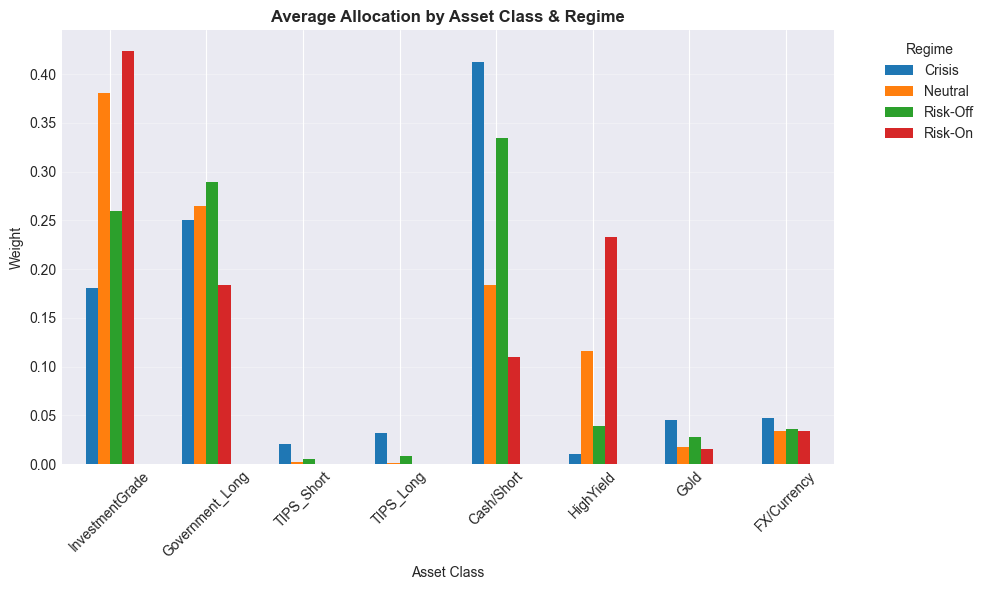


 Average allocation analysis complete


In [39]:
# Average Allocation by Class & Regime
import matplotlib.pyplot as plt

print("\n" + "="*70)
print(" " * 15 + "AVERAGE ALLOCATION BY CLASS & REGIME")
print("="*70)

# Build class-level allocations from smoothed weights
cls_rule = pd.DataFrame(index=smoothed_weights_rule.index)

for asset_class in SAA_WEIGHTS.keys():
    class_assets = [a for a, c in asset_to_class.items() if c == asset_class and a in smoothed_weights_rule.columns]
    if class_assets:
        cls_rule[asset_class] = smoothed_weights_rule[class_assets].sum(axis=1)
    else:
        cls_rule[asset_class] = 0.0

# Add regime labels
regime_aligned = ind['Regime_quantile'].reindex(cls_rule.index).ffill()
cls_rule_with_regime = cls_rule.copy()
cls_rule_with_regime['regime'] = regime_aligned

# Calculate averages by regime
avg_by_class_regime = cls_rule_with_regime.groupby('regime').mean()

print(avg_by_class_regime.round(4))
print("="*70)

# Save CSV
if WRITE_OUTPUTS:
    avg_by_class_regime.to_csv(OUTPUT_DIR / "avg_allocation_by_class_regime.csv")
    print(f"\n Saved: avg_allocation_by_class_regime.csv")

# Visualization
if not avg_by_class_regime.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    avg_by_class_regime.T.plot(kind='bar', ax=ax, rot=45)
    ax.set_title('Average Allocation by Asset Class & Regime', fontsize=12, fontweight='bold')
    ax.set_ylabel('Weight')
    ax.set_xlabel('Asset Class')
    ax.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    if WRITE_OUTPUTS:
        plt.savefig(OUTPUT_DIR / 'avg_allocation_by_regime.png', dpi=300, bbox_inches='tight')
        print(f" Plot saved: avg_allocation_by_regime.png")
    
    plt.show()

print("\n Average allocation analysis complete")

## Export Results

In [40]:
if WRITE_OUTPUTS:
    for method in smoothed_quant.keys():
        smoothed_quant[method].sort_index().to_csv(OUTPUT_DIR / f"weights_{method}.csv")
    
    smoothed_weights_rule.sort_index().to_csv(OUTPUT_DIR / "weights_RuleBased.csv")
    
    print(" All weight files saved")
    print(f"\nOutput directory: {OUTPUT_DIR.absolute()}")
    print(f"  - indicators_processed.csv")
    print(f"  - performance_metrics.csv")
    print(f"  - regime_performance.csv")
    print(f"  - strategy_returns.csv")
    print(f"  - weights_RiskParity.csv")
    print(f"  - weights_SharpeWeighted.csv")
    print(f"  - weights_MeanVariance.csv")
    print(f"  - weights_RuleBased.csv")
    print(f"  - regime_visualization.png")
    print(f"  - cumulative_returns.png")

 All weight files saved

Output directory: c:\Users\abdul\Desktop\New folder\Regime-Aware-Fixed-Income-Portfolio-Allocation-Model\Outputs
  - indicators_processed.csv
  - performance_metrics.csv
  - regime_performance.csv
  - strategy_returns.csv
  - weights_RiskParity.csv
  - weights_SharpeWeighted.csv
  - weights_MeanVariance.csv
  - weights_RuleBased.csv
  - regime_visualization.png
  - cumulative_returns.png


## 16. Period Analysis (Scenario Analysis)

**Objective:** Test strategy performance across diverse market environments

**Crisis/Scenario Windows:**
1. **Calm_2017_2019:** Risk-on baseline environment
2. **Dotcom Bust (2000-2002):** Technology bubble collapse
3. **GFC (2007-2009):** Global Financial Crisis - **showcase period**
4. **COVID (2020):** Pandemic-induced volatility
5. **Inflation2022 (2021-2022):** Simultaneous bond/equity selloff
6. **2024 Volatility:** Recent market turbulence

**Benchmark Strategies:**
- SAA: Strategic Asset Allocation (baseline)
- Barbell_LongShort: 50% Gov Long + 50% Cash
- Barbell_Diversified: 40% Gov Long + 40% Cash + 20% IG
- Capital_Preservation: 45% IG + 35% Gov + 15% Cash + 5% TIPS
- Gov_Long_Only: 100% Government bonds

**Metrics:**
- Max Drawdown, VaR/CVaR, 12-month loss probability
- **Preservation Score:** Weighted ranking (40% MaxDD, 35% VaR, 25% ProbLoss)
 - Lower score = better capital preservation


In [41]:
# Benchmarks & Crisis Allocations Export
print("\n" + "="*70)
print(" " * 15 + "BENCHMARKS & CRISIS ALLOCATIONS EXPORT")
print("="*70)

# Helper function: convert class targets to asset weights
def class_targets_to_asset_weights(class_targets):
    class_to_assets = {}
    for a, c in asset_to_class.items():
        class_to_assets.setdefault(c, []).append(a)
    
    out = pd.Series(0.0, index=assets.columns)
    for cl, wt in class_targets.items():
        members = class_to_assets.get(cl, [])
        if len(members) > 0:
            per = wt / len(members)
            out.loc[members] = out.loc[members] + per
    
    if out.sum() > 0:
        out = out / out.sum()
    return out

# Define benchmark strategies
benchmarks_class_targets = {
    'SAA': SAA_WEIGHTS,
    'Barbell_LongShort': {'Government_Long': 0.50, 'Cash/Short': 0.50},
    'Barbell_Diversified': {'Government_Long': 0.40, 'Cash/Short': 0.40, 'InvestmentGrade': 0.20},
    'Capital_Preservation': {'InvestmentGrade': 0.45, 'Government_Long': 0.35, 'Cash/Short': 0.15, 'TIPS': 0.05},
    'Gov_Long_Only': {'Government_Long': 1.0}
}

# Normalize
for name, clt in list(benchmarks_class_targets.items()):
    s = sum(clt.values())
    benchmarks_class_targets[name] = {k: v / s for k, v in clt.items()}

# Convert to asset-level weights
benchmarks_asset_weights = {}
for name, class_targets in benchmarks_class_targets.items():
    w_asset = class_targets_to_asset_weights(class_targets)
    benchmarks_asset_weights[name] = w_asset

# Save benchmark snapshot
if WRITE_OUTPUTS:
    pd.DataFrame(benchmarks_asset_weights).to_csv(OUTPUT_DIR / "benchmarks_asset_weights_snapshot.csv")
    print(" Saved: benchmarks_asset_weights_snapshot.csv")

# Define crisis windows
crisis_windows = {
    
    'dotcom_bust': (pd.Timestamp('2000-01-01'), pd.Timestamp('2002-12-31')),
    'GFC': (pd.Timestamp('2007-07-01'), pd.Timestamp('2009-12-31')),
    'Calm_2017_2019': (pd.Timestamp('2017-01-01'), pd.Timestamp('2019-12-31')),
    'Covid': (pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31')),
    'Inflation2022': (pd.Timestamp('2021-07-01'), pd.Timestamp('2022-12-31')),
    '2024_vol': (pd.Timestamp('2024-01-01'), pd.Timestamp('2024-12-31'))
}

# Build allocation time series for all methods
all_methods_alloc_assets = {}

# Rule-based
all_methods_alloc_assets['Rule'] = smoothed_weights_rule.reindex(
    index=assets.index, columns=assets.columns
).fillna(method='ffill').fillna(0.0)

# Benchmarks (constant weights)
for name, w in benchmarks_asset_weights.items():
    df_const = pd.DataFrame([w.values], columns=w.index, index=[assets.index[0]])
    all_methods_alloc_assets[name] = df_const.reindex(index=assets.index).ffill().fillna(0.0)

# Helper: aggregate to class level
def aggregate_by_class(weights_df):
    classes = {}
    for a, c in asset_to_class.items():
        classes.setdefault(c, []).append(a)
    
    df_class = pd.DataFrame(index=weights_df.index)
    for cl, members in classes.items():
        present = [x for x in members if x in weights_df.columns]
        if present:
            df_class[cl] = weights_df[present].sum(axis=1)
        else:
            df_class[cl] = 0.0
    
    row_sums = df_class.sum(axis=1).replace(0, 1.0)
    return df_class.div(row_sums, axis=0)

# Calculate average allocations per crisis window
asset_level_crisis_avg = {}
class_level_crisis_avg = {}

for win_name, (s, e) in crisis_windows.items():
    mask = (assets.index >= s) & (assets.index <= e)
    if mask.sum() == 0:
        continue
    
    aset_df = pd.DataFrame(index=assets.columns)
    cls_df = pd.DataFrame(index=sorted(set(asset_to_class.values())))
    
    for mname, w_ts in all_methods_alloc_assets.items():
        w_sub = w_ts.loc[mask].reindex(columns=assets.columns).fillna(0.0)
        aset_df[mname] = w_sub.mean(axis=0)
        
        cls_sub = aggregate_by_class(w_sub)
        cls_df[mname] = cls_sub.mean(axis=0)
    
    asset_level_crisis_avg[win_name] = aset_df
    class_level_crisis_avg[win_name] = cls_df
    
    if WRITE_OUTPUTS:
        aset_df.to_csv(OUTPUT_DIR / f"allocations_asset_avg_{win_name}.csv")
        cls_df.to_csv(OUTPUT_DIR / f"allocations_class_avg_{win_name}.csv")
        print(f" Saved avg allocations for {win_name}")

# Save monthly allocation workbooks per window
if WRITE_OUTPUTS:
    for win_name, (s, e) in crisis_windows.items():
        mask = (assets.index >= s) & (assets.index <= e)
        if mask.sum() == 0:
            continue
        
        out_xl = OUTPUT_DIR / f"allocations_monthly_{win_name}.xlsx"
        with pd.ExcelWriter(out_xl, engine='openpyxl') as w:
            for mname, w_ts in all_methods_alloc_assets.items():
                w_sub = w_ts.loc[mask].reindex(columns=assets.columns).fillna(0.0)
                w_sub.to_excel(w, sheet_name=str(mname)[:31])
        print(f" Saved monthly workbook: {win_name}")
    
    # Summary workbook
    summary_file = OUTPUT_DIR / "crisis_allocations_summary.xlsx"
    with pd.ExcelWriter(summary_file, engine='openpyxl') as writer:
        for win_name, cls_df in class_level_crisis_avg.items():
            cls_df.T.to_excel(writer, sheet_name=str(win_name)[:31])
    print(f"\n Saved crisis allocations summary: crisis_allocations_summary.xlsx")

# Display sample for key periods
for win in ['GFC', 'Covid']:
    if win in class_level_crisis_avg:
        print(f"\nAverage CLASS allocations during {win}:")
        print(class_level_crisis_avg[win].round(3).T)

print("\n" + "="*70)
print(" Benchmarks & Crisis Allocations Export complete")
print("="*70)


               BENCHMARKS & CRISIS ALLOCATIONS EXPORT
 Saved: benchmarks_asset_weights_snapshot.csv
 Saved avg allocations for dotcom_bust
 Saved avg allocations for GFC
 Saved avg allocations for Calm_2017_2019
 Saved avg allocations for Covid
 Saved avg allocations for Inflation2022
 Saved avg allocations for 2024_vol
 Saved monthly workbook: dotcom_bust
 Saved monthly workbook: GFC
 Saved monthly workbook: Calm_2017_2019
 Saved monthly workbook: Covid
 Saved monthly workbook: Inflation2022
 Saved monthly workbook: 2024_vol

 Saved crisis allocations summary: crisis_allocations_summary.xlsx

Average CLASS allocations during GFC:
                      Cash/Short  FX/Currency   Gold  Government_Long  \
Rule                       0.277        0.034  0.057            0.285   
SAA                        0.096        0.019  0.019            0.288   
Barbell_LongShort          0.500        0.000  0.000            0.500   
Barbell_Diversified        0.400        0.000  0.000            0.40

In [42]:
# Crisis-Period Downside KPIs + Preservation Ranking
print("\n" + "="*70)
print(" " * 15 + "CRISIS-PERIOD DOWNSIDE KPIs")
print("="*70)

alpha = 0.05
monthly_freq = 12

# Collect return series
all_methods_rets = {}

# Rule-Based and SAA from primary strategies
all_methods_rets['Rule'] = rule_returns
all_methods_rets['SAA'] = saa_benchmark_returns

# Build benchmark returns from asset weights
for name, w in benchmarks_asset_weights.items():
    w_ser = pd.Series(w).reindex(assets.columns).fillna(0.0)
    all_methods_rets[name] = (assets * w_ser.values).sum(axis=1)

# Downside KPI functions
def emp_var(series, alpha=0.05):
    s = series.dropna()
    return float(s.quantile(alpha)) if not s.empty else np.nan

def emp_cvar(series, alpha=0.05):
    s = series.dropna()
    if s.empty:
        return np.nan
    var = s.quantile(alpha)
    tail = s[s <= var]
    return float(tail.mean()) if not tail.empty else float(var)

def prob_loss_rolling(series, window_months=12):
    s = series.dropna()
    if len(s) < window_months:
        return np.nan
    rolling = (1 + s).rolling(window_months).apply(lambda x: x.prod(), raw=False) - 1.0
    valid = rolling.dropna()
    return float((valid < 0).sum() / valid.shape[0]) if valid.shape[0] > 0 else np.nan

def worst_rolling(series, window_months=12):
    s = series.dropna()
    if len(s) < window_months:
        return np.nan
    rolling = (1 + s).rolling(window_months).apply(lambda x: x.prod(), raw=False) - 1.0
    return float(rolling.min())

def compute_downside_kpis(series, alpha=0.05):
    s = series.dropna()
    if s.empty:
        return {col: np.nan for col in ['CumRet', 'AnnRet', 'AnnVol', 'Sharpe', 'MaxDD', 'VaR5', 'CVaR5', 'ProbLoss12m', 'Worst12m']}
    
    cum = (1 + s).prod() - 1
    ann = s.mean() * monthly_freq
    annvol = s.std(ddof=1) * np.sqrt(monthly_freq)
    sharpe = ann / annvol if annvol > 0 else np.nan
    
    wealth = (1 + s).cumprod()
    maxdd = (wealth / wealth.cummax() - 1).min()
    
    var = emp_var(s, alpha)
    cvar = emp_cvar(s, alpha)
    pl12 = prob_loss_rolling(s, 12)
    w12 = worst_rolling(s, 12)
    
    return {
        'CumRet': cum, 'AnnRet': ann, 'AnnVol': annvol, 'Sharpe': sharpe,
        'MaxDD': maxdd, 'VaR5': var, 'CVaR5': cvar,
        'ProbLoss12m': pl12, 'Worst12m': w12
    }

# Calculate KPIs for each crisis window
all_window_tables = {}
preservation_weights = {'MaxDD': 0.4, 'VaR5': 0.35, 'ProbLoss12m': 0.25}

for win_name, (start_ts, end_ts) in crisis_windows.items():
    mask = (assets.index >= start_ts) & (assets.index <= end_ts)
    if mask.sum() == 0:
        continue
    
    records = {}
    for mname, series in all_methods_rets.items():
        sub = series.loc[mask].dropna()
        records[mname] = compute_downside_kpis(sub, alpha)
    
    df_win = pd.DataFrame.from_dict(records, orient='index')
    
    # Calculate Preservation Score (lower = better)
    df_win['_mag_MaxDD'] = df_win['MaxDD'].abs()
    df_win['_mag_VaR'] = df_win['VaR5'].abs()
    df_win['_mag_ProbLoss12m'] = df_win['ProbLoss12m'].fillna(0.0)
    
    # Rank (1 = best)
    for col in ['_mag_MaxDD', '_mag_VaR', '_mag_ProbLoss12m']:
        df_win[col + '_rank'] = df_win[col].rank(method='min', ascending=True, na_option='bottom')
    
    # Normalize ranks to [0,1]
    n = df_win.shape[0]
    if n > 1:
        r_maxdd = (df_win['_mag_MaxDD_rank'] - 1) / (n - 1)
        r_var = (df_win['_mag_VaR_rank'] - 1) / (n - 1)
        r_prob = (df_win['_mag_ProbLoss12m_rank'] - 1) / (n - 1)
    else:
        r_maxdd = r_var = r_prob = pd.Series(0.0, index=df_win.index)
    
    df_win['PreservationScore'] = (
        preservation_weights['MaxDD'] * r_maxdd +
        preservation_weights['VaR5'] * r_var +
        preservation_weights['ProbLoss12m'] * r_prob
    )
    
    # Drop temp columns
    df_win = df_win[[c for c in df_win.columns if not c.startswith('_mag')]]
    
    all_window_tables[win_name] = df_win
    
    if WRITE_OUTPUTS:
        df_win.to_csv(OUTPUT_DIR / f"crisis_downside_performance_{win_name}.csv")
        df_win.sort_values('PreservationScore').to_csv(
            OUTPUT_DIR / f"crisis_downside_ranked_{win_name}.csv"
        )
        print(f" Saved crisis KPIs for {win_name}")
    
    # Display top 5 by preservation
    print(f"\n--- Top 5 by Preservation Score: {win_name} ---")
    top5 = df_win.sort_values('PreservationScore').head(5)[['MaxDD', 'VaR5', 'ProbLoss12m', 'PreservationScore']]
    print(top5.round(4))

# Combined output
if WRITE_OUTPUTS and all_window_tables:
    combined_df = pd.concat(all_window_tables, axis=0)
    combined_df.to_csv(OUTPUT_DIR / "crisis_downside_performance_ALL.csv")
    print(f"\n Saved combined crisis KPIs: crisis_downside_performance_ALL.csv")

print("\n" + "="*70)
print(" Crisis-Period Downside KPIs + Preservation Ranking complete")
print("="*70)


               CRISIS-PERIOD DOWNSIDE KPIs
 Saved crisis KPIs for dotcom_bust

--- Top 5 by Preservation Score: dotcom_bust ---
                       MaxDD    VaR5  ProbLoss12m  PreservationScore
Rule                 -0.0166 -0.0059          0.0               0.00
SAA                  -0.0205 -0.0119          0.0               0.15
Barbell_Diversified  -0.0304 -0.0131          0.0               0.30
Barbell_LongShort    -0.0331 -0.0139          0.0               0.45
Capital_Preservation -0.0342 -0.0151          0.0               0.60
 Saved crisis KPIs for GFC

--- Top 5 by Preservation Score: GFC ---
                       MaxDD    VaR5  ProbLoss12m  PreservationScore
Rule                 -0.0345 -0.0132       0.0000               0.00
Barbell_Diversified  -0.0390 -0.0202       0.0526               0.20
Barbell_LongShort    -0.0535 -0.0217       0.0526               0.42
Capital_Preservation -0.0539 -0.0264       0.0526               0.57
SAA                  -0.0757 -0.0212       